# The Advantage of Being Small - A Model For Individual Investors

## Introduction

Equity markets consist of some of the most studied data in the world. With millions invested into research, and computational tools beyond what's accessible to the average individual, it's not hard to see that an individual investor doing their own analysis will have a tough time outperforming. Currently, I see two paths to success:

1. **Find a strategy the institutions haven't:** while possible, this is unlikely to happen considering the disparity in resources spent on the problem. You'd have to be incredibly lucky, and even still it's probably only a matter of time before an institution catches on, at which point any alpha is lost.


2. **Find a strategy that institutions can't implement:** while the large amount of resources gives institutions ample opportunity, they also impose limitations. In particular, investing large amounts of capital has an impact on the market by moving equity prices and as a result signalling the rest of the market. This effect is especially pronounced in smaller caps. Moving large blocks of stock can be difficult and imprecise. 

The second point presents an opportunity, and is the basis for this project. 

Imagine a stock with a 500m market cap, that has been choppy for the past two years, moving cyclically between \\$4.50 and \\$5.50. An institution sets a buy price at \\$5.00 and sell at \\$5.10, hoping to lock in a 2\% gain every trade. Putting in an order to buy 100k shares at \\$5.00 will likely settle in blocks. Depending on the liquidity of the stock, executing such a large order will push up the stock price. In all likelihood, some blocks will settle at \\$5.00, some at \\$5.01... etc. Selling those 100k shares will have the opposite effect, pushing down the price during execution of the order. The result is far from the 2\% expected return (and even has the potential to be negative depending on how much the order moves the stock price). Buying 100 shares; however, will likely settle in a single block, and thus face no such issues. 

### Methodology

This project will follow the following framework:

1. Retrieve stock price data from the web using the yfinance package.


2. Design functions to:

    a) Filter stocks whose price has stayed within a given range for a given amount of time. 
    
    b) Backtest to find optimal buy and sell price of the given stock for iterative buys/sells within the given window.
    
    c) Calculate future returns given the optimal buy and sell price above.


3. Optimize parameters to improve filtering (remove stocks with negative future returns). 


4. Benchmark performance against SPY. 


I want to address the issue of relying on backtesting to predict future stock returns. The goal of this project is to find stocks that have been trading within a fixed range for an extended period of time, with the assumption that that will continue. Of course, not all stocks will continue to trade in the same pattern. However, by optimizing filters and implementing a tight stop, my hypothesis is that the success stories can outweigh those that don't. 

Like any other predictive model, overfitting to the training data by tuning the model parameters too specifically to the backtest can easily result in poorer actual returns. In this project, I have aimed to strike a balance between fine-tuning the model and avoiding overfitting, but it remains a concern that needs to be acknowledged.

In [2]:
# Import packages
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
#from datetime import date, datetime, timedelta
from pandas.tseries.offsets import QuarterEnd
import matplotlib.pyplot as plt

## 1. Retrieve stock price data

To optimize the runtime and avoid unnecessary data downloads, I decided to generate a CSV file containing the price data for all the required tickers. This approach proved beneficial, particularly when tuning the model's parameters as it significantly reduced the runtime. Additionally, since I had to access data from the same tickers repeatedly, using a CSV file ensured data consistency and eliminated any concerns of discrepancies caused by downloading data multiple times.

Seperate CSVs were created for closing, high, and low prices. 

In [3]:
#create CSVs to store price data as opposed to downloading it throughout (much faster since I will be accessing
#.  data from the same tickers repeatedly)
start_date = datetime.date(2018,1,1)
end_date = datetime.date(2023,4,1)

tickers = pd.read_csv('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/' + 
                      'Equity-market-analysis/tickers.csv')
tickers = tickers.rename(columns = {"A": "Ticker"})
tickers = tickers["Ticker"]

In [ ]:
#create CSVs 
closing_price_data = pd.DataFrame()
high_price_data = pd.DataFrame()
low_price_data = pd.DataFrame()

downloaded_tickers = []

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, interval="1d", progress=False)
        
    closing_price_data = pd.concat([closing_price_data, data['Close']], axis=1)
    high_price_data = pd.concat([high_price_data, data['High']], axis=1)
    low_price_data = pd.concat([low_price_data, data['Low']], axis=1)
    
closing_price_data.columns = tickers.values
high_price_data.columns = tickers.values
low_price_data.columns = tickers.values

closing_price_data.to_csv('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/' + 
                          'Equity-market-analysis/closing_price_data.csv', index=True)

high_price_data.to_csv('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/' + 
                          'Equity-market-analysis/high_price_data.csv', index=True)

low_price_data.to_csv('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/' + 
                          'Equity-market-analysis/low_price_data.csv', index=True)

The closing price data is then cleaned and loaded below. 

In [4]:
#since csv can't store axis, need to reset it

def load_price_csvs(path):
    """
    Load and set index of the given CSV.
    Meant for use on closing, high, and low price data files.
    """

    price_data = pd.read_csv(path)
    price_data = price_data.set_index("Unnamed: 0")
    price_data = price_data.rename_axis("Date")
    
    return price_data

high_price_data = load_price_csvs('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/Equity-ma' \
                      'rket-analysis/high_price_data.csv')

low_price_data = load_price_csvs('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/Equity-ma' \
                      'rket-analysis/low_price_data.csv')

closing_price_data = load_price_csvs('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/Equity-ma' \
                      'rket-analysis/closing_price_data.csv')

Given my hypothesis that this strategy would perform better on smaller market cap stocks, I divided the price data into three groups based on market cap: small, mid, and large. This allowed me to test the strategy's effectiveness across different market cap categories. 

Important to note that this is the present day market cap. Ideally I would scrape for historical data but this is a good place to start. 

In [5]:
market_cap_dict = {}

for ticker in tickers:
    try:
        mcap = yf.Ticker(ticker).fast_info['marketCap']
        market_cap_dict.update({ticker:mcap})
    except: KeyError #ignore tickers with no market cap available

In [6]:
# create dicts of tickers for each market cap
small_caps_dict = {k: v for k, v in market_cap_dict.items() if v < 2_000_000_000}
mid_caps_dict = {k: v for k, v in market_cap_dict.items() if 2_000_000_000 <= v <= 10_000_000_000}
large_caps_dict = {k: v for k, v in market_cap_dict.items() if v > 10_000_000_000}

# retrieve the tickers (keys) for each dict
small_cap_tickers = small_caps_dict.keys()
mid_cap_tickers = mid_caps_dict.keys()
large_cap_tickers = large_caps_dict.keys()

# filter the original price data for only the tickers with that market cap
small_cap_price_data = closing_price_data[small_cap_tickers]
mid_cap_price_data = closing_price_data[mid_cap_tickers]
large_cap_price_data = closing_price_data[large_cap_tickers]

I also created a dataframe with both small and mid cap stocks, in the event that both work successfully. 

In [7]:
small_mid_price_data = pd.concat([small_cap_price_data, mid_cap_price_data], axis=1)

In [150]:
closing_price_data.iloc[0,:]

AA       55.169998
AAC            NaN
AAN            NaN
AAP     106.089996
AAT      38.160000
           ...    
ZS             NaN
ZT             NaN
ZUMZ     20.000000
ZYME      7.933000
ZYXI      3.009091
Name: 2018-01-02 00:00:00, Length: 3798, dtype: float64

## 2. Design functions

### 2a. Filter stocks

The first function needs to filter stocks to keep only those with minimal variability. It does so by ensuring the price stays within a specified range of the mean within the given window.  

In [161]:
def min_var_filter(price_data, model_start_date, var=0.1, period=200):
    
    """
    Return dict of {tickers:price adjusted stdev} for stocks whose price stays within var% of of the mean price
        in period days prior to the model_start_days.
        
    If max/min price too high/low set var to -1.
    Else find var to make sure price isn't TOO stable.

    """
    # set date range
    start_date = str(model_start_date - datetime.timedelta(period))
    end_date = str(model_start_date)
    
    # retrieve data and drop nan
    stock_data = closing_price_data.loc[start_date:end_date]
    nan_cols = stock_data.columns[stock_data.iloc[0].isna()]
    stock_data = stock_data.drop(columns=nan_cols)
    
    var_dict = {}

    def calc_var(closing_price_data, column):
        """
        If the given ticker's max and min price is within var% of the mean, return it and the price adjusted
            deviation. 
        Else return the ticker and -1. 
        """
        ticker = column.name

        avg_close = np.mean(closing_price_data)
        max_close = np.max(closing_price_data)
        min_close = np.min(closing_price_data)

        upper_bound = (1+var)*avg_close
        lower_bound = (1-var)*avg_close

        # check prices
        # if price stays within bounds, calculate variability
        if (max_close > upper_bound) or (min_close < lower_bound):
            pv = -1
        else:         
            closing_std_dev = np.std(closing_price_data) 
            pv = closing_std_dev / avg_close #price adjusted deviation

        return (ticker, pv)

    # use dictionary comprehension to filter out negative values
    var_dict = {key: val for key, val in [calc_var(stock_data[col_name], stock_data[col_name]) 
                                          for col_name in stock_data.columns] if val >= 0}

    return var_dict


### 2b. Backtest to find optimal buy and sell price

For each stock found above, we'll do a backtest to find the buy and sell prices that maximize returns over the given period. 

In [167]:
def back_calculate_returns(list_of_stocks, start_date, end_date):
    """
    Find and print the optimal buy and sell price of each stock in the given list over the given range
    Also gives total % returns over that period.
    
    Initially tried vectorized buy and sell functions, but actually increased runtime so reverted to for-loops.
    """
    
    def retrieve_stock_data(stock, start_date, end_date):
        """Return high and low price data for the given stock in the given date range"""
        high_data = high_price_data.loc[start_date:end_date][stock].round(2)
        low_data = low_price_data.loc[start_date:end_date][stock].round(2)
        
        stock_data = pd.concat([high_data, low_data], axis=1)
        stock_data.columns = ["High", "Low"]
        
        return stock_data
    
    def init(stock_data):
        min_low = np.min(stock_data["Low"])
        max_high = np.max(stock_data["High"])
        increment = (min_low / 100) + 0.01
  
        return min_low, max_high, increment
        
    
    def find_best_buy_sell(stock_data, min_low, max_high, increment, 
                           owned=False, max_profit=0, best_buy=0, best_sell=0):
        """
        Find the best buy and sell prices for a given stock using the given price data and price range
        """
        buy_prices = np.arange(min_low, max_high, increment)

        for buy_price in buy_prices:
            sell_prices = np.arange(buy_price, max_high, increment)

            for sell_price in sell_prices:
                profit = 0.
                owned = False

                for index, row in stock_data.iterrows():
                    if owned:
                        if (row["High"] >= sell_price):
                            profit += (sell_price - buy_price)
                            owned = False
                    else:
                        if (row["Low"] <= buy_price):
                            owned = True

                if (profit > max_profit):
                    max_profit = round(profit, 2)
                    best_sell = round(sell_price, 2)
                    best_buy = round(buy_price, 2)

        return max_profit, best_sell, best_buy
             
    returns = {}
    
    for stock in list_of_stocks:
        stock_data = retrieve_stock_data(stock, start_date, end_date)
        min_low, max_high, increment = init(stock_data)
        max_profit, best_sell, best_buy = find_best_buy_sell(stock_data, min_low, max_high, increment)
        percent_return = max_profit / best_buy * 100 if best_buy != 0 else 0
        num_buys_sells = round(max_profit / (best_sell - best_buy)) if best_buy != 0 else 0
        pct_price_change = (high_price_data.iloc[-1, :][stock] - high_price_data.iloc[0, :][stock]) / high_price_data.iloc[0, :][stock]

        print(f"The profit for {stock} is {max_profit} at buy price: {best_buy} and sell price: {best_sell}")
        print(f"That equates to a {percent_return}% return")

        returns.update({stock : {"buy_price" : best_buy, "sell_price" : best_sell, 
                "min_low" : min_low, "max_high" : max_high, 'percent_return' : percent_return, 
                       'num_buys_sells' : num_buys_sells, 'pct_price_change' : pct_price_change}})
    
    return returns


### 2c. Calculate future returns

Lastly, we need a function that uses the optimal buy and sell prices above to simulate this strategy over the given interval. 

In [154]:
def front_calculate_returns(dict_of_stocks, start_date, end_date):
    """
    Calculate returns over given interval for each stock using buy/sell prices within the given dict. 
    
    Sell out if price goes below min low (also within the given dict).
    """
    
    def retrieve_stock_data(stock, start_date, end_date):
        """Return high and low price data for the given stock in the given date range"""
        high_data = high_price_data.loc[start_date:end_date][stock].round(2)
        low_data = low_price_data.loc[start_date:end_date][stock].round(2)
        
        stock_data = pd.concat([high_data, low_data], axis=1)
        stock_data.columns = ["High", "Low"]
        
        return stock_data
    
    def calculate_returns(stock_data, buy_price, sell_price, min_low):
        owned = False
        profit = 0.

        for index, row in stock_data.iterrows():
            #break if you leave the lower bound of the backtest data
            if (row["Low"] < min_low):
                if (owned):
                    profit += row["Low"]
                break
            elif (owned):
                if (row["High"] >= sell_price):
                    profit += sell_price
                    owned = False
                # sell at the low price (to be conservative) on end date if still owned
                elif (index == stock_data.index[-1]):
                    profit += row["Low"]
                    owned = False
            else:
                if (row["Low"] <= buy_price):
                    profit -= row["Low"]
                    owned = True
        
        return profit
    
    fwd_returns_dict = {}  

    for ticker in dict_of_stocks:
        
        prices = dict_of_stocks[ticker]
        buy_price = prices["buy_price"]
        sell_price = prices["sell_price"]
        min_low = prices["min_low"]
        max_high = prices["max_high"]
        
        stock_data = retrieve_stock_data(ticker, start_date, end_date)
        stock_data = stock_data.round(2)

        profit = calculate_returns(stock_data, buy_price, sell_price, min_low)

        try:
            percent_return = profit / buy_price * 100
        except ZeroDivisionError:
            percent_return = 0
        
        print(f"The profit for {ticker} is {profit}")
        print(f"That equates to a {percent_return}% return")
        
        fwd_returns_dict.update({ticker:percent_return})
        
    return fwd_returns_dict

In [155]:
test_dates = pd.period_range(start='2018-12-31', end='2022-12-31', freq='Q').strftime('%Y-%m-%d').tolist()

extracted_date = datetime.datetime.strptime(test_dates[0], '%Y-%m-%d')
model_start_date = datetime.date(extracted_date.year, extracted_date.month, extracted_date.day)


## Single method for cumulative returns

In [159]:
test_dates = pd.period_range(start='2018-12-31', end='2022-12-31', freq='Q').strftime('%Y-%m-%d').tolist()

def list_of_returns_calc(price_data, var, dates, back_days, front_days):
    
    var_ret = {}
    back_ret = {}
    fwd_ret = {}
    
    for date in dates:
        extracted_date = datetime.datetime.strptime(date, '%Y-%m-%d')
        model_start_date = datetime.date(extracted_date.year, extracted_date.month, extracted_date.day)
        print(model_start_date)
        
        var_dict = min_var_filter(price_data, var=var, model_start_date=model_start_date, period=back_days)
        ticker_list = list(var_dict.keys())
        var_ret.update(var_dict)
        print(ticker_list)
        
        back_start_date = str(model_start_date - datetime.timedelta(back_days))
        back_end_date = str(model_start_date)
        back_returns = back_calculate_returns(ticker_list, back_start_date, back_end_date)
        back_ret.update(back_returns)
        
        fwd_start_date = str(model_start_date) 
        fwd_end_date = str(model_start_date + datetime.timedelta(front_days) )
        fwd_ret.update(front_calculate_returns(back_returns, fwd_start_date, fwd_end_date))
        
    return var_ret, back_ret, fwd_ret

In [37]:
#old version before ML
test_dates = pd.period_range(start='2018-12-31', end='2022-12-31', freq='Q').strftime('%Y-%m-%d').tolist()

def list_of_returns_calc(price_data, var, dates, back_days, front_days):
    
    rets = []
    
    for date in dates:
        extracted_date = datetime.datetime.strptime(date, '%Y-%m-%d')
        model_start_date = datetime.date(extracted_date.year, extracted_date.month, extracted_date.day)
        print(model_start_date)
        
        var_dict = min_var_filter(price_data, var=var, model_start_date=model_start_date, period=back_days)
        ticker_list = list(var_dict.keys())
        print(ticker_list)
        
        start_date = str(model_start_date - datetime.timedelta(back_days))
        end_date = str(model_start_date)
        back_returns = back_calculate_returns(ticker_list, start_date, end_date)
        
        start_date = str(model_start_date) 
        end_date = str(model_start_date + datetime.timedelta(front_days) )
        rets.append(front_calculate_returns(back_returns, start_date, end_date))
        
    print(rets)
    return rets

In [42]:
import math
def cum_ret(list_of_list_of_rets):
    for i in range(len(list_of_list_of_rets)):
        list_i = list_of_list_of_rets[i]
        newi = []
        for x in list_i:
            if not math.isnan(x):
                newi.append(x)
        cum_ret = 1
        for x in newi:
            cum_ret *= (1+ x/100)
        cum_ret = (cum_ret - 1) * 100
        print(f"total cumulatic returns = {cum_ret}%")

In [168]:
var_df, back_df, fwd_df = list_of_returns_calc(small_cap_price_data, 0.075, test_dates, 150, 90)

2018-12-31
['ACEL', 'AFB', 'AIV', 'AJG', 'ALE', 'AQN', 'ATO', 'AVB', 'BAP', 'BBN', 'BCE', 'BCH', 'BFK', 'BFZ', 'BHK', 'BHP', 'BLE', 'BSAC', 'BTT', 'BTZ', 'CCI', 'CHT', 'CMS', 'CNA', 'CNP', 'CTOS', 'D', 'DEO', 'DTE', 'ED', 'EFC', 'EPRT', 'ESS', 'ETR', 'EVN', 'FCPT', 'FE', 'FTS', 'GB', 'GBAB', 'GHY', 'GIM', 'GPMT', 'GSK', 'HSY', 'ICE', 'IDA', 'IIM', 'IQI', 'KO', 'KOF', 'KREF', 'KT', 'KTF', 'LEO', 'LIN', 'LSI', 'MHN', 'MIN', 'MIY', 'MMD', 'MQY', 'MUA', 'MUC', 'MUI', 'MUJ', 'MVF', 'MYD', 'MYI', 'MYN', 'NAC', 'NAD', 'NAN', 'NBB', 'NEA', 'NEE', 'NHI', 'NI', 'NID', 'NKX', 'NLY', 'NMZ', 'NQP', 'NRK', 'NUV', 'NVG', 'NVS', 'NXJ', 'NXP', 'NZF', 'OGS', 'ORAN', 'PACK', 'PEG', 'PFE', 'PML', 'PMM', 'PMO', 'POR', 'RCI', 'RE', 'RSG', 'SGU', 'SKM', 'SPCE', 'SR', 'SRE', 'SUI', 'SWX', 'UDR', 'UGI', 'UL', 'UTL', 'VCV', 'VGM', 'VKQ', 'VMO', 'VRT', 'WF', 'WIT', 'WIW', 'WM', 'WPC', 'AGNC', 'AHCO', 'AY', 'AZN', 'BIOX', 'BROG', 'ERIE', 'EVRG', 'EXC', 'GCBC', 'HIFS', 'HPK', 'IGIC', 'JJSF', 'LNT', 'NKLA', 'NRC', 

The profit for MUJ is 0.53 at buy price: 12.25 and sell price: 12.78
That equates to a 4.326530612244898% return
The profit for MVF is 0.54 at buy price: 8.16 and sell price: 8.7
That equates to a 6.61764705882353% return
The profit for MYD is 1.2 at buy price: 12.29 and sell price: 13.49
That equates to a 9.764035801464606% return
The profit for MYI is 0.5 at buy price: 11.54 and sell price: 12.04
That equates to a 4.332755632582322% return
The profit for MYN is 0.85 at buy price: 11.21 and sell price: 11.33
That equates to a 7.582515611061551% return
The profit for NAC is 0.8 at buy price: 12.38 and sell price: 12.52
That equates to a 6.462035541195476% return
The profit for NAD is 0.53 at buy price: 12.37 and sell price: 12.64
That equates to a 4.284559417946646% return
The profit for NAN is 0.65 at buy price: 12.15 and sell price: 12.28
That equates to a 5.349794238683128% return
The profit for NBB is 0.79 at buy price: 18.9 and sell price: 19.29
That equates to a 4.17989417989418%

The profit for NRC is 18.66 at buy price: 38.14 and sell price: 39.24
That equates to a 48.92501310959622% return
The profit for NWE is 9.16 at buy price: 56.23 and sell price: 65.39
That equates to a 16.290236528543485% return
The profit for ORGO is 1.36 at buy price: 9.47 and sell price: 10.83
That equates to a 14.361140443505807% return
The profit for OSW is 0.32 at buy price: 9.75 and sell price: 10.07
That equates to a 3.282051282051282% return
The profit for RPAY is 0.21 at buy price: 9.6 and sell price: 9.81
That equates to a 2.1875% return
The profit for SNY is 8.25 at buy price: 42.74 and sell price: 44.8
That equates to a 19.30276087973795% return
The profit for TFSL is 2.73 at buy price: 15.25 and sell price: 15.71
That equates to a 17.901639344262296% return
The profit for TH is 0.43 at buy price: 9.7 and sell price: 10.13
That equates to a 4.43298969072165% return
The profit for THRY is 0.99 at buy price: 10.0 and sell price: 10.99
That equates to a 9.9% return
The profit 

['ABB', 'ACEL', 'AFB', 'AGR', 'ALE', 'BCE', 'BFK', 'BFZ', 'BHK', 'BRW', 'BSAC', 'BTT', 'BTZ', 'CAJ', 'CHT', 'CIM', 'CLX', 'CTOS', 'CUBE', 'D', 'DUK', 'DX', 'EFT', 'ESE', 'EVN', 'FRA', 'FSR', 'GB', 'GHY', 'GIM', 'GPMT', 'GSK', 'HEP', 'HRL', 'HSBC', 'HSY', 'ICE', 'IIM', 'IQI', 'JQC', 'KO', 'KREF', 'KTF', 'LEO', 'LSI', 'MCD', 'MHN', 'MIN', 'MIY', 'MMD', 'MQY', 'MUC', 'MUI', 'MUJ', 'MVF', 'MYD', 'MYI', 'MYN', 'NAC', 'NAD', 'NAN', 'NBB', 'NEA', 'NID', 'NKX', 'NLY', 'NQP', 'NRK', 'NUV', 'NVG', 'NXJ', 'NXP', 'NZF', 'OIA', 'ORAN', 'PACK', 'PML', 'PMM', 'PMO', 'PPT', 'PRS', 'RCI', 'RE', 'SGU', 'SNN', 'SPCE', 'STC', 'TEF', 'THG', 'TLK', 'TM', 'TU', 'UGI', 'UL', 'VCV', 'VGM', 'VKQ', 'VMO', 'VRT', 'WIW', 'WTM', 'AGNC', 'AHCO', 'BROG', 'CFFN', 'CLBK', 'DGICA', 'DJCO', 'DSGR', 'EVRG', 'FCUV', 'GCBC', 'GDYN', 'HPK', 'IGIC', 'LPRO', 'NKLA', 'NRC', 'PEP', 'RPAY', 'SNY', 'TH', 'THRY', 'USLM', 'WDFC', 'WSBF']
The profit for ABB is 2.86 at buy price: 19.0 and sell price: 19.57
That equates to a 15.0526315

The profit for NQP is 1.17 at buy price: 12.02 and sell price: 13.19
That equates to a 9.733777038269551% return
The profit for NRK is 1.25 at buy price: 11.49 and sell price: 12.74
That equates to a 10.879025239338555% return
The profit for NUV is 1.21 at buy price: 9.22 and sell price: 9.83
That equates to a 13.123644251626898% return
The profit for NVG is 1.72 at buy price: 13.3 and sell price: 15.02
That equates to a 12.932330827067668% return
The profit for NXJ is 1.35 at buy price: 12.47 and sell price: 13.82
That equates to a 10.82598235765838% return
The profit for NXP is 1.32 at buy price: 13.92 and sell price: 14.36
That equates to a 9.482758620689657% return
The profit for NZF is 1.96 at buy price: 13.01 and sell price: 14.97
That equates to a 15.06533435818601% return
The profit for OIA is 1.02 at buy price: 6.85 and sell price: 7.87
That equates to a 14.890510948905112% return
The profit for ORAN is 1.58 at buy price: 14.84 and sell price: 16.42
That equates to a 10.646900

['AAT', 'AB', 'ACEL', 'ACRE', 'ADC', 'ADX', 'AEE', 'AFB', 'AFG', 'AGR', 'AIV', 'AKR', 'ALEX', 'AOD', 'APLE', 'ARI', 'ATO', 'AVA', 'AVB', 'AVK', 'AWF', 'AWP', 'AWR', 'AXS', 'BBDC', 'BBN', 'BCE', 'BCSF', 'BCX', 'BDJ', 'BFK', 'BFZ', 'BGB', 'BGR', 'BGY', 'BHK', 'BIP', 'BIT', 'BLE', 'BLW', 'BME', 'BMO', 'BN', 'BNS', 'BOE', 'BOH', 'BP', 'BRC', 'BRK-A', 'BRK-B', 'BRT', 'BRW', 'BRX', 'BTT', 'BTZ', 'BUI', 'BWXT', 'BXMT', 'BXMX', 'BXP', 'CAJ', 'CBZ', 'CCU', 'CEM', 'CHH', 'CHT', 'CII', 'CIM', 'CL', 'CLX', 'CMS', 'CNA', 'CNP', 'CPF', 'CPK', 'CPT', 'CSR', 'CTO', 'CTOS', 'CUZ', 'CVX', 'CWT', 'D', 'DCI', 'DEA', 'DEI', 'DFP', 'DIAX', 'DLB', 'DNP', 'DOC', 'DOV', 'DPG', 'DRH', 'DSL', 'DSU', 'DTE', 'DUK', 'ECVT', 'EFC', 'EFR', 'EFT', 'EGP', 'EMD', 'EMO', 'ENB', 'EOI', 'EOS', 'EPD', 'EPR', 'EQC', 'EQR', 'ESS', 'ETB', 'ETG', 'ETJ', 'ETN', 'ETV', 'ETW', 'ETY', 'EVN', 'EVT', 'EXG', 'FCPT', 'FE', 'FEI', 'FFA', 'FFC', 'FOF', 'FPF', 'FR', 'FRA', 'FRT', 'FSD', 'FSK', 'FSR', 'GAB', 'GB', 'GBAB', 'GD', 'GDV', 'GHI

The profit for BOH is 20.46 at buy price: 76.3 and sell price: 83.12
That equates to a 26.815203145478378% return
The profit for BP is 4.96 at buy price: 41.15 and sell price: 42.39
That equates to a 12.053462940461726% return
The profit for BRC is 8.07 at buy price: 44.28 and sell price: 48.31
That equates to a 18.224932249322492% return
The profit for BRK-A is 47344.16 at buy price: 298859.01 and sell price: 310695.05
That equates to a 15.841637165297442% return
The profit for BRK-B is 31.66 at buy price: 198.87 and sell price: 206.78
That equates to a 15.919947704530598% return
The profit for BRT is 4.02 at buy price: 12.53 and sell price: 13.87
That equates to a 32.08300079808459% return
The profit for BRW is 0.51 at buy price: 9.49 and sell price: 9.59
That equates to a 5.374077976817703% return
The profit for BRX is 3.56 at buy price: 17.35 and sell price: 18.07
That equates to a 20.51873198847262% return
The profit for BTT is 1.58 at buy price: 21.64 and sell price: 23.22
That e

The profit for ETV is 1.18 at buy price: 13.77 and sell price: 14.95
That equates to a 8.569353667392884% return
The profit for ETW is 0.62 at buy price: 9.6 and sell price: 9.7
That equates to a 6.458333333333334% return
The profit for ETY is 1.91 at buy price: 11.17 and sell price: 12.12
That equates to a 17.099373321396598% return
The profit for EVN is 0.76 at buy price: 11.6 and sell price: 12.36
That equates to a 6.551724137931035% return
The profit for EVT is 3.08 at buy price: 20.97 and sell price: 24.05
That equates to a 14.687649022412971% return
The profit for EXG is 0.87 at buy price: 7.84 and sell price: 8.28
That equates to a 11.096938775510203% return
The profit for FCPT is 4.16 at buy price: 27.59 and sell price: 28.98
That equates to a 15.077926785067053% return
The profit for FE is 5.87 at buy price: 38.11 and sell price: 43.98
That equates to a 15.402781422198899% return
The profit for FEI is 1.44 at buy price: 11.61 and sell price: 11.97
That equates to a 12.40310077

The profit for KKR is 8.28 at buy price: 23.16 and sell price: 23.85
That equates to a 35.751295336787564% return
The profit for KMF is 1.66 at buy price: 11.1 and sell price: 11.93
That equates to a 14.954954954954955% return
The profit for KRC is 11.08 at buy price: 72.42 and sell price: 77.96
That equates to a 15.299640983153825% return
The profit for KREF is 2.06 at buy price: 20.01 and sell price: 20.42
That equates to a 10.294852573713143% return
The profit for KTF is 0.58 at buy price: 10.67 and sell price: 11.25
That equates to a 5.435801312089971% return
The profit for KW is 3.08 at buy price: 19.51 and sell price: 22.59
That equates to a 15.786776012301381% return
The profit for KYN is 2.21 at buy price: 15.74 and sell price: 16.05
That equates to a 14.040660736975857% return
The profit for LDP is 1.69 at buy price: 23.17 and sell price: 24.86
That equates to a 7.293914544669831% return
The profit for LEO is 0.69 at buy price: 7.58 and sell price: 8.27
That equates to a 9.102

The profit for PGRE is 2.32 at buy price: 14.26 and sell price: 14.55
That equates to a 16.269284712482467% return
The profit for PML is 2.02 at buy price: 13.42 and sell price: 15.44
That equates to a 15.052160953800298% return
The profit for PMM is 0.65 at buy price: 7.09 and sell price: 7.74
That equates to a 9.16784203102962% return
The profit for PMO is 0.9 at buy price: 11.79 and sell price: 12.69
That equates to a 7.633587786259542% return
The profit for PMT is 3.11 at buy price: 20.78 and sell price: 21.4
That equates to a 14.966313763233877% return
The profit for PNW is 13.9 at buy price: 85.85 and sell price: 99.75
That equates to a 16.191030867792662% return
The profit for PPG is 22.96 at buy price: 105.45 and sell price: 116.93
That equates to a 21.77335229966809% return
The profit for PPL is 4.59 at buy price: 30.53 and sell price: 31.45
That equates to a 15.03439240091713% return
The profit for PPT is 0.36 at buy price: 5.06 and sell price: 5.18
That equates to a 7.114624

The profit for VFC is 15.79 at buy price: 81.1 and sell price: 88.99
That equates to a 19.469790382244142% return
The profit for VGM is 0.65 at buy price: 11.99 and sell price: 12.64
That equates to a 5.421184320266889% return
The profit for VICI is 2.62 at buy price: 21.94 and sell price: 22.82
That equates to a 11.941659070191431% return
The profit for VKQ is 0.64 at buy price: 11.72 and sell price: 12.36
That equates to a 5.460750853242321% return
The profit for VMO is 0.51 at buy price: 11.69 and sell price: 12.2
That equates to a 4.362703165098375% return
The profit for VNO is 10.22 at buy price: 66.7 and sell price: 67.98
That equates to a 15.322338830584709% return
The profit for VRT is 0.32 at buy price: 9.83 and sell price: 10.15
That equates to a 3.255340793489318% return
The profit for VVR is 0.3 at buy price: 4.16 and sell price: 4.31
That equates to a 7.211538461538461% return
The profit for WDS is 6.19 at buy price: 24.49 and sell price: 25.73
That equates to a 25.2756227

The profit for MPB is 10.14 at buy price: 24.02 and sell price: 25.15
That equates to a 42.214820982514574% return
The profit for NBTB is 7.76 at buy price: 35.35 and sell price: 39.23
That equates to a 21.951909476661953% return
The profit for NFLX is 140.13 at buy price: 342.66 and sell price: 366.02
That equates to a 40.894764489581505% return
The profit for NKLA is 0.33 at buy price: 9.85 and sell price: 10.18
That equates to a 3.3502538071065993% return
The profit for NMFC is 1.14 at buy price: 13.97 and sell price: 14.12
That equates to a 8.160343593414458% return
The profit for NWBI is 2.42 at buy price: 16.99 and sell price: 17.16
That equates to a 14.243672748675692% return
The profit for NWPX is 11.54 at buy price: 23.0 and sell price: 25.31
That equates to a 50.17391304347826% return
The profit for NYMT is 2.95 at buy price: 23.85 and sell price: 25.32
That equates to a 12.368972746331238% return
The profit for OBNK is 11.76 at buy price: 33.97 and sell price: 34.95
That equ

['AAT', 'ABB', 'ACEL', 'ACRE', 'ADX', 'AEE', 'AFB', 'AFG', 'AGR', 'AIV', 'AJG', 'AKR', 'ALC', 'ALE', 'ALEX', 'ALK', 'ALTG', 'AME', 'AMH', 'AOD', 'AON', 'APLE', 'ARE', 'ARI', 'ASH', 'ATO', 'ATR', 'AVB', 'AVK', 'AWF', 'AWP', 'AXP', 'BBDC', 'BBN', 'BCE', 'BCH', 'BCX', 'BDJ', 'BDN', 'BFK', 'BFZ', 'BGB', 'BGY', 'BHK', 'BIT', 'BKH', 'BLE', 'BLW', 'BME', 'BOE', 'BRK-A', 'BRK-B', 'BRW', 'BSAC', 'BTI', 'BTT', 'BTZ', 'BXMT', 'BXMX', 'BXP', 'CB', 'CBU', 'CHD', 'CHT', 'CII', 'CIM', 'CL', 'CLX', 'CM', 'CNA', 'CNI', 'CNP', 'CNS', 'CP', 'CPF', 'CPK', 'CPT', 'CRH', 'CSL', 'CTRE', 'CUBE', 'CVX', 'D', 'DEI', 'DEO', 'DFP', 'DGX', 'DHR', 'DIAX', 'DIS', 'DM', 'DNP', 'DPG', 'DRI', 'DSL', 'DSU', 'DTE', 'DUK', 'EBF', 'ED', 'EFC', 'EFR', 'EFT', 'EIG', 'ELME', 'EMD', 'EME', 'ENB', 'EOI', 'EOS', 'EPD', 'EPR', 'EQC', 'EQH', 'ETB', 'ETG', 'ETJ', 'ETV', 'ETW', 'ETY', 'EVA', 'EVN', 'EVT', 'EXG', 'FBK', 'FCF', 'FCPT', 'FEI', 'FFA', 'FFC', 'FOF', 'FPF', 'FRA', 'FRT', 'FSD', 'FSK', 'FSR', 'FTS', 'GAB', 'GAM', 'GB', 'GB

The profit for BHK is 1.29 at buy price: 13.35 and sell price: 14.64
That equates to a 9.662921348314606% return
The profit for BIT is 1.05 at buy price: 16.7 and sell price: 17.22
That equates to a 6.2874251497006% return
The profit for BKH is 12.81 at buy price: 72.28 and sell price: 78.69
That equates to a 17.72274488101826% return
The profit for BLE is 1.66 at buy price: 14.06 and sell price: 15.72
That equates to a 11.806543385490754% return
The profit for BLW is 1.24 at buy price: 14.52 and sell price: 15.76
That equates to a 8.539944903581267% return
The profit for BME is 4.76 at buy price: 37.8 and sell price: 38.16
That equates to a 12.592592592592593% return
The profit for BOE is 0.55 at buy price: 10.17 and sell price: 10.72
That equates to a 5.408062930186825% return
The profit for BRK-A is 47121.92 at buy price: 297456.12 and sell price: 321017.08
That equates to a 15.84163741529339% return
The profit for BRK-B is 31.42 at buy price: 197.36 and sell price: 213.08
That equa

The profit for ETG is 1.89 at buy price: 15.54 and sell price: 16.48
That equates to a 12.162162162162163% return
The profit for ETJ is 0.9 at buy price: 9.24 and sell price: 9.34
That equates to a 9.740259740259742% return
The profit for ETV is 1.77 at buy price: 13.77 and sell price: 15.54
That equates to a 12.854030501089325% return
The profit for ETW is 0.82 at buy price: 9.39 and sell price: 9.6
That equates to a 8.73269435569755% return
The profit for ETY is 1.45 at buy price: 11.36 and sell price: 12.09
That equates to a 12.764084507042254% return
The profit for EVA is 4.16 at buy price: 29.6 and sell price: 31.68
That equates to a 14.054054054054054% return
The profit for EVN is 0.91 at buy price: 12.07 and sell price: 12.98
That equates to a 7.539353769676885% return
The profit for EVT is 2.76 at buy price: 23.19 and sell price: 24.57
That equates to a 11.901681759379041% return
The profit for EXG is 1.04 at buy price: 7.84 and sell price: 8.36
That equates to a 13.26530612244

The profit for JPM is 23.17 at buy price: 105.39 and sell price: 116.98
That equates to a 21.985008065281335% return
The profit for JPS is 1.0 at buy price: 8.99 and sell price: 9.99
That equates to a 11.123470522803114% return
The profit for JQC is 0.33 at buy price: 7.32 and sell price: 7.65
That equates to a 4.508196721311475% return
The profit for JRI is 1.69 at buy price: 16.59 and sell price: 17.43
That equates to a 10.186859553948162% return
The profit for JRO is 0.21 at buy price: 9.41 and sell price: 9.62
That equates to a 2.2316684378320932% return
The profit for KMB is 25.24 at buy price: 128.97 and sell price: 141.58
That equates to a 19.57044273862138% return
The profit for KMI is 3.24 at buy price: 19.64 and sell price: 20.45
That equates to a 16.4969450101833% return
The profit for KOF is 8.13 at buy price: 61.1 and sell price: 62.26
That equates to a 13.30605564648118% return
The profit for KRC is 11.74 at buy price: 73.09 and sell price: 78.96
That equates to a 16.0623

The profit for PBA is 5.36 at buy price: 36.16 and sell price: 37.23
That equates to a 14.823008849557526% return
The profit for PDI is 3.76 at buy price: 31.25 and sell price: 32.5
That equates to a 12.032% return
The profit for PDM is 2.42 at buy price: 19.99 and sell price: 20.79
That equates to a 12.106053026513257% return
The profit for PDT is 1.58 at buy price: 16.51 and sell price: 18.09
That equates to a 9.569957601453664% return
The profit for PEG is 9.0 at buy price: 58.65 and sell price: 60.9
That equates to a 15.34526854219949% return
The profit for PFN is 0.87 at buy price: 9.85 and sell price: 10.28
That equates to a 8.832487309644671% return
The profit for PHK is 0.69 at buy price: 7.79 and sell price: 7.88
That equates to a 8.857509627727856% return
The profit for PML is 1.56 at buy price: 14.59 and sell price: 16.15
That equates to a 10.692254969156958% return
The profit for PMM is 0.59 at buy price: 7.44 and sell price: 8.03
That equates to a 7.930107526881719% return

The profit for WCN is 8.9 at buy price: 90.63 and sell price: 92.41
That equates to a 9.820147853911509% return
The profit for WIW is 0.59 at buy price: 10.72 and sell price: 11.31
That equates to a 5.503731343283581% return
The profit for WSO is 32.36 at buy price: 154.64 and sell price: 165.43
That equates to a 20.92602172788412% return
The profit for XYL is 13.32 at buy price: 73.74 and sell price: 80.4
That equates to a 18.063466232709523% return
The profit for ZTR is 1.02 at buy price: 10.78 and sell price: 11.12
That equates to a 9.461966604823749% return
The profit for ADP is 28.13 at buy price: 159.95 and sell price: 169.32
That equates to a 17.58674585808065% return
The profit for AEP is 12.53 at buy price: 87.57 and sell price: 91.75
That equates to a 14.308553157474021% return
The profit for AHCO is 0.33 at buy price: 10.01 and sell price: 10.34
That equates to a 3.296703296703297% return
The profit for ALGT is 40.39 at buy price: 141.7 and sell price: 144.39
That equates to

The profit for JKHY is 19.53 at buy price: 129.22 and sell price: 148.75
That equates to a 15.113759479956665% return
The profit for KRNY is 1.6 at buy price: 12.72 and sell price: 13.52
That equates to a 12.578616352201259% return
The profit for LAMR is 9.8 at buy price: 79.66 and sell price: 80.41
That equates to a 12.302284710017576% return
The profit for LANC is 22.38 at buy price: 147.29 and sell price: 150.09
That equates to a 15.194514223640438% return
The profit for LAND is 1.35 at buy price: 11.55 and sell price: 11.67
That equates to a 11.688311688311687% return
The profit for LAZR is 0.98 at buy price: 9.85 and sell price: 10.83
That equates to a 9.949238578680204% return
The profit for LBRDA is 19.04 at buy price: 97.07 and sell price: 106.59
That equates to a 19.614711033274958% return
The profit for LBRDK is 21.39 at buy price: 97.22 and sell price: 107.92
That equates to a 22.001645751902903% return
The profit for LPRO is 0.11 at buy price: 10.02 and sell price: 10.13
Th

['AAT', 'ABC', 'ABT', 'ACCO', 'ACRE', 'ADX', 'AEE', 'AFB', 'AFG', 'AGR', 'AHH', 'AIV', 'AJG', 'ALC', 'ALE', 'ALL', 'ALTG', 'AMH', 'AN', 'AOD', 'AON', 'AQN', 'ARI', 'ARR', 'ASH', 'ATO', 'ATR', 'AUB', 'AVA', 'AVB', 'AVK', 'AWF', 'AWI', 'AWK', 'AWP', 'AXP', 'BAP', 'BBDC', 'BBN', 'BCE', 'BCSF', 'BCX', 'BDJ', 'BDN', 'BFK', 'BFZ', 'BG', 'BGB', 'BGY', 'BHK', 'BIT', 'BKH', 'BLE', 'BLW', 'BME', 'BOE', 'BP', 'BR', 'BRK-A', 'BRW', 'BST', 'BSTZ', 'BTT', 'BTZ', 'BUI', 'BVN', 'BXMT', 'BXMX', 'BXP', 'CAE', 'CAJ', 'CAPL', 'CB', 'CHE', 'CHT', 'CII', 'CIM', 'CL', 'CLVT', 'CMS', 'CNI', 'CPF', 'CPK', 'CPT', 'CVX', 'CWT', 'D', 'DAL', 'DEI', 'DEO', 'DFP', 'DGX', 'DIAX', 'DKL', 'DM', 'DNP', 'DOC', 'DPG', 'DSL', 'DSU', 'DTE', 'DUK', 'E', 'ECL', 'ED', 'EFC', 'EFR', 'EFT', 'EFX', 'EIG', 'EMD', 'EME', 'EOI', 'EOS', 'EQC', 'ES', 'ESRT', 'ESS', 'ETB', 'ETJ', 'ETO', 'ETV', 'ETW', 'ETY', 'EVN', 'EVT', 'F', 'FBK', 'FCPT', 'FFA', 'FFC', 'FHI', 'FHN', 'FINS', 'FIS', 'FMX', 'FNF', 'FOF', 'FPF', 'FRA', 'FRT', 'FSD', 'FSR

The profit for BCX is 0.99 at buy price: 7.33 and sell price: 7.83
That equates to a 13.506139154160982% return
The profit for BDJ is 1.16 at buy price: 8.63 and sell price: 9.79
That equates to a 13.441483198146% return
The profit for BDN is 1.8 at buy price: 14.93 and sell price: 15.53
That equates to a 12.056262558606832% return
The profit for BFK is 0.87 at buy price: 13.75 and sell price: 14.18
That equates to a 6.327272727272727% return
The profit for BFZ is 0.43 at buy price: 13.34 and sell price: 13.77
That equates to a 3.223388305847077% return
The profit for BG is 11.06 at buy price: 52.71 and sell price: 56.4
That equates to a 20.98273572377158% return
The profit for BGB is 0.88 at buy price: 13.68 and sell price: 14.56
That equates to a 6.432748538011696% return
The profit for BGY is 0.56 at buy price: 5.27 and sell price: 5.83
That equates to a 10.62618595825427% return
The profit for BHK is 0.9 at buy price: 14.29 and sell price: 14.59
That equates to a 6.298110566829952%

The profit for EQC is 3.16 at buy price: 30.96 and sell price: 32.54
That equates to a 10.20671834625323% return
The profit for ES is 10.71 at buy price: 75.48 and sell price: 86.19
That equates to a 14.18918918918919% return
The profit for ESRT is 2.48 at buy price: 13.61 and sell price: 14.85
That equates to a 18.221895664952243% return
The profit for ESS is 40.91 at buy price: 291.19 and sell price: 332.1
That equates to a 14.049246196641368% return
The profit for ETB is 2.09 at buy price: 15.05 and sell price: 17.14
That equates to a 13.88704318936877% return
The profit for ETJ is 0.91 at buy price: 9.27 and sell price: 9.37
That equates to a 9.81661272923409% return
The profit for ETO is 3.0 at buy price: 24.78 and sell price: 26.28
That equates to a 12.106537530266344% return
The profit for ETV is 1.53 at buy price: 14.75 and sell price: 15.05
That equates to a 10.372881355932204% return
The profit for ETW is 1.13 at buy price: 9.29 and sell price: 10.42
That equates to a 12.1636

The profit for IRM is 6.3 at buy price: 31.15 and sell price: 34.3
That equates to a 20.224719101123593% return
The profit for ISD is 1.06 at buy price: 14.1 and sell price: 15.16
That equates to a 7.517730496453902% return
The profit for ITGR is 25.56 at buy price: 70.71 and sell price: 79.23
That equates to a 36.14764531183708% return
The profit for IVT is 0 at buy price: 0 and sell price: 0
That equates to a 0% return
The profit for JBGS is 3.8 at buy price: 39.28 and sell price: 40.04
That equates to a 9.674134419551935% return
The profit for JCI is 7.42 at buy price: 41.89 and sell price: 42.71
That equates to a 17.71305800907138% return
The profit for JFR is 0.73 at buy price: 9.37 and sell price: 10.1
That equates to a 7.790821771611527% return
The profit for JPC is 0.84 at buy price: 9.53 and sell price: 10.37
That equates to a 8.814270724029381% return
The profit for JPI is 1.96 at buy price: 23.56 and sell price: 25.52
That equates to a 8.31918505942275% return
The profit for

The profit for NTR is 7.02 at buy price: 48.16 and sell price: 50.5
That equates to a 14.57641196013289% return
The profit for NUV is 0.45 at buy price: 10.23 and sell price: 10.68
That equates to a 4.398826979472141% return
The profit for NVG is 1.01 at buy price: 16.19 and sell price: 16.52
That equates to a 6.238418777022853% return
The profit for NVS is 11.05 at buy price: 83.97 and sell price: 95.02
That equates to a 13.159461712516377% return
The profit for NXJ is 0.61 at buy price: 14.15 and sell price: 14.76
That equates to a 4.31095406360424% return
The profit for NXP is 1.46 at buy price: 15.25 and sell price: 16.71
That equates to a 9.573770491803279% return
The profit for NZF is 1.32 at buy price: 15.61 and sell price: 16.27
That equates to a 8.456117873158233% return
The profit for OFC is 3.9 at buy price: 27.68 and sell price: 29.62
That equates to a 14.089595375722544% return
The profit for OGE is 6.36 at buy price: 42.24 and sell price: 43.51
That equates to a 15.056818

The profit for SYK is 31.71 at buy price: 213.01 and sell price: 220.94
That equates to a 14.886625041077886% return
The profit for TD is 7.62 at buy price: 54.53 and sell price: 58.34
That equates to a 13.973959288465066% return
The profit for TDF is 2.96 at buy price: 18.6 and sell price: 19.34
That equates to a 15.913978494623654% return
The profit for TEL is 20.64 at buy price: 89.32 and sell price: 94.48
That equates to a 23.107926556202422% return
The profit for THG is 17.79 at buy price: 127.34 and sell price: 136.24
That equates to a 13.970472750117793% return
The profit for THW is 1.25 at buy price: 13.05 and sell price: 13.47
That equates to a 9.578544061302681% return
The profit for TLK is 3.38 at buy price: 28.87 and sell price: 30.56
That equates to a 11.707655005195704% return
The profit for TR is 5.62 at buy price: 32.09 and sell price: 34.9
That equates to a 17.51324400124649% return
The profit for TRI is 13.1 at buy price: 66.45 and sell price: 67.76
That equates to a 

The profit for CHCO is 10.96 at buy price: 73.54 and sell price: 77.2
That equates to a 14.90345390263802% return
The profit for CHI is 1.11 at buy price: 10.25 and sell price: 10.47
That equates to a 10.829268292682928% return
The profit for CHKP is 16.98 at buy price: 107.25 and sell price: 111.5
That equates to a 15.832167832167832% return
The profit for CHY is 0.94 at buy price: 10.7 and sell price: 11.64
That equates to a 8.785046728971963% return
The profit for CINF is 13.48 at buy price: 103.73 and sell price: 117.21
That equates to a 12.995276197821267% return
The profit for CMCSA is 7.51 at buy price: 43.64 and sell price: 44.89
That equates to a 17.2089825847846% return
The profit for CME is 31.49 at buy price: 199.73 and sell price: 207.6
That equates to a 15.766284484053472% return
The profit for COLM is 29.24 at buy price: 92.03 and sell price: 101.78
That equates to a 31.77224817994132% return
The profit for CSQ is 1.7 at buy price: 12.11 and sell price: 13.81
That equate

The profit for TCPC is 1.69 at buy price: 13.26 and sell price: 13.68
That equates to a 12.745098039215685% return
The profit for THRY is 0 at buy price: 0 and sell price: 0
That equates to a 0% return
The profit for TMUS is 12.05 at buy price: 76.57 and sell price: 78.08
That equates to a 15.737233903617605% return
The profit for TOWN is 3.73 at buy price: 26.68 and sell price: 28.55
That equates to a 13.980509745127437% return
The profit for TRMK is 5.88 at buy price: 33.61 and sell price: 34.59
That equates to a 17.49479321630467% return
The profit for TXN is 23.12 at buy price: 116.9 and sell price: 121.53
That equates to a 19.7775876817793% return
The profit for UMBF is 12.24 at buy price: 65.07 and sell price: 68.13
That equates to a 18.810511756569852% return
The profit for UVSP is 5.3 at buy price: 25.5 and sell price: 26.26
That equates to a 20.784313725490193% return
The profit for WABC is 10.13 at buy price: 58.56 and sell price: 68.69
That equates to a 17.298497267759565% r

The profit for FINS is -1.1700000000000017
That equates to a -5.698977106673169% return
The profit for FIS is 0.0
That equates to a 0.0% return
The profit for FMX is -2.250000000000014
That equates to a -2.4763372220999496% return
The profit for FNF is 0.0
That equates to a 0.0% return
The profit for FOF is 0.0
That equates to a 0.0% return
The profit for FPF is 0.0
That equates to a 0.0% return
The profit for FRA is 0.0
That equates to a 0.0% return
The profit for FRT is 0.0
That equates to a 0.0% return
The profit for FSD is 0.0
That equates to a 0.0% return
The profit for FSR is 0.0
That equates to a 0.0% return
The profit for FTS is -1.2999999999999972
That equates to a -3.28614762386248% return
The profit for G is 0.0
That equates to a 0.0% return
The profit for GAB is 0.20999999999999996
That equates to a 3.482587064676616% return
The profit for GAM is 0.0
That equates to a 0.0% return
The profit for GB is -0.08000000000000007
That equates to a -0.7874015748031503% return
The pro

The profit for PTY is 0.0
That equates to a 0.0% return
The profit for RA is 0.0
That equates to a 0.0% return
The profit for RC is 0.25
That equates to a 1.6046213093709885% return
The profit for RCI is 0.0
That equates to a 0.0% return
The profit for RELX is 0.7699999999999996
That equates to a 3.25994919559695% return
The profit for RLI is 4.320000000000022
That equates to a 4.850117884809725% return
The profit for RMM is 0.0
That equates to a 0.0% return
The profit for RMT is 0.0
That equates to a 0.0% return
The profit for RNR is -10.560000000000002
That equates to a -5.687510098561967% return
The profit for ROP is -21.139999999999986
That equates to a -6.0736654599781605% return
The profit for RQI is -0.9399999999999995
That equates to a -6.262491672218518% return
The profit for RSG is 0.0
That equates to a 0.0% return
The profit for RVT is 0.0
That equates to a 0.0% return
The profit for RWT is 0.0
That equates to a 0.0% return
The profit for RY is 0.0
That equates to a 0.0% ret

The profit for NYMT is 0.0
That equates to a 0.0% return
The profit for OBT is 0.0
That equates to a 0.0% return
The profit for OCSL is 0.370000000000001
That equates to a 2.4151436031331657% return
The profit for ONB is 0.0
That equates to a 0.0% return
The profit for OSIS is -2.1699999999999875
That equates to a -2.285894869904127% return
The profit for PAYX is -3.5200000000000102
That equates to a -4.377564979480177% return
The profit for PFG is 5.6200000000000045
That equates to a 10.599773670313098% return
The profit for PRGS is 0.0
That equates to a 0.0% return
The profit for PSEC is 0.0
That equates to a 0.0% return
The profit for QQQX is 0.0
That equates to a 0.0% return
The profit for RELL is 0.09999999999999964
That equates to a 1.8050541516245424% return
The profit for RMR is -0.10000000000000142
That equates to a -0.2313208420078682% return
The profit for ROIC is -0.5199999999999996
That equates to a -2.9663434112949205% return
The profit for SAFT is -7.109999999999999
That

['AEVA', 'AFB', 'BFZ', 'BHK', 'BME', 'BXMX', 'CABO', 'CHT', 'DLY', 'ED', 'ETB', 'EVN', 'FINS', 'FRA', 'FREY', 'GBAB', 'GIM', 'HQH', 'HQL', 'HRL', 'IGD', 'IIM', 'IQI', 'IVT', 'JBI', 'JNJ', 'JQC', 'KTF', 'MIN', 'MIY', 'MMD', 'MMU', 'MUI', 'MYN', 'NAC', 'NAD', 'NAN', 'NEA', 'NGG', 'NID', 'NKX', 'NQP', 'NRK', 'NVO', 'NVS', 'NXJ', 'ORCC', 'PRS', 'RMM', 'TAK', 'THQ', 'THW', 'UWMC', 'VCV', 'VGM', 'VKQ', 'VMO', 'ARKO', 'ARTNA', 'ASLE', 'ASTS', 'ATRI', 'AVPT', 'BLDE', 'GCMG', 'INDI', 'MVST', 'NWTN', 'OBT', 'PEP', 'PRCH', 'PROC', 'REYN', 'SBAC', 'SNY', 'THRY', 'VRSN']
The profit for AEVA is 0.64 at buy price: 9.82 and sell price: 10.03
That equates to a 6.517311608961303% return
The profit for AFB is 1.61 at buy price: 12.44 and sell price: 14.05
That equates to a 12.942122186495178% return
The profit for BFZ is 1.85 at buy price: 12.23 and sell price: 14.08
That equates to a 15.126737530662307% return
The profit for BHK is 1.98 at buy price: 14.2 and sell price: 16.18
That equates to a 13.94366

The profit for OBT is 1.22 at buy price: 23.55 and sell price: 23.8
That equates to a 5.1804670912951165% return
The profit for PEP is 26.78 at buy price: 130.36 and sell price: 134.18
That equates to a 20.54311138386008% return
The profit for PRCH is 1.93 at buy price: 9.75 and sell price: 11.68
That equates to a 19.794871794871792% return
The profit for PROC is 0.32 at buy price: 9.75 and sell price: 10.07
That equates to a 3.282051282051282% return
The profit for REYN is 11.22 at buy price: 32.66 and sell price: 35.47
That equates to a 34.35394978567055% return
The profit for SBAC is 83.21 at buy price: 295.78 and sell price: 309.64
That equates to a 28.13239569950639% return
The profit for SNY is 8.59 at buy price: 51.04 and sell price: 51.99
That equates to a 16.829937304075234% return
The profit for THRY is 0 at buy price: 0 and sell price: 0
That equates to a 0% return
The profit for VRSN is 54.87 at buy price: 206.71 and sell price: 214.54
That equates to a 26.544434231532094% 

The profit for AZO is 228.24 at buy price: 1118.46 and sell price: 1194.54
That equates to a 20.406630545571588% return
The profit for BBN is 2.6 at buy price: 25.26 and sell price: 26.56
That equates to a 10.292953285827394% return
The profit for BFK is 1.88 at buy price: 13.5 and sell price: 15.38
That equates to a 13.925925925925926% return
The profit for BFZ is 1.25 at buy price: 12.9 and sell price: 14.15
That equates to a 9.689922480620154% return
The profit for BGB is 1.26 at buy price: 11.73 and sell price: 12.36
That equates to a 10.741687979539643% return
The profit for BHK is 1.14 at buy price: 15.27 and sell price: 16.41
That equates to a 7.465618860510805% return
The profit for BIT is 2.1 at buy price: 15.15 and sell price: 17.25
That equates to a 13.861386138613863% return
The profit for BLE is 2.74 at buy price: 14.54 and sell price: 15.46
That equates to a 18.844566712517196% return
The profit for BLW is 1.82 at buy price: 14.16 and sell price: 15.98
That equates to a 1

The profit for MUJ is 1.01 at buy price: 13.5 and sell price: 14.51
That equates to a 7.481481481481482% return
The profit for MVF is 0.67 at buy price: 8.52 and sell price: 9.19
That equates to a 7.863849765258217% return
The profit for MYD is 1.27 at buy price: 13.12 and sell price: 14.39
That equates to a 9.679878048780488% return
The profit for MYI is 0.99 at buy price: 13.2 and sell price: 14.19
That equates to a 7.5% return
The profit for MYN is 0.8 at buy price: 12.39 and sell price: 13.19
That equates to a 6.456820016142049% return
The profit for NAC is 0.77 at buy price: 14.36 and sell price: 15.13
That equates to a 5.362116991643454% return
The profit for NAD is 0.92 at buy price: 14.26 and sell price: 15.18
That equates to a 6.451612903225806% return
The profit for NAN is 1.14 at buy price: 13.22 and sell price: 14.36
That equates to a 8.623298033282904% return
The profit for NBB is 2.68 at buy price: 21.3 and sell price: 23.98
That equates to a 12.582159624413144% return
Th

The profit for BTT is 0.4299999999999997
That equates to a 1.7158818834796479% return
The profit for BTZ is 0.0
That equates to a 0.0% return
The profit for CAG is -0.35999999999999943
That equates to a -1.027397260273971% return
The profit for CCI is -4.439999999999998
That equates to a -2.6923776605421126% return
The profit for CHCT is -1.4799999999999969
That equates to a -3.245614035087712% return
The profit for CHT is 0.0
That equates to a 0.0% return
The profit for CL is 0.0
That equates to a 0.0% return
The profit for DFP is 0.0
That equates to a 0.0% return
The profit for DLY is 0.0
That equates to a 0.0% return
The profit for DNP is 0.3200000000000003
That equates to a 3.1872509960159396% return
The profit for DOC is 3.1299999999999955
That equates to a 17.855105533371336% return
The profit for DSL is 0.0
That equates to a 0.0% return
The profit for DSU is 0.0
That equates to a 0.0% return
The profit for EFR is 0.0
That equates to a 0.0% return
The profit for EFT is 0.0
That e

The profit for ADC is 18.68 at buy price: 63.76 and sell price: 67.5
That equates to a 29.29736511919699% return
The profit for AFB is 1.02 at buy price: 13.6 and sell price: 14.62
That equates to a 7.5% return
The profit for AMCR is 3.4 at buy price: 10.67 and sell price: 11.8
That equates to a 31.865042174320525% return
The profit for BCE is 7.41 at buy price: 42.25 and sell price: 45.96
That equates to a 17.53846153846154% return
The profit for BFZ is 1.67 at buy price: 12.9 and sell price: 14.57
That equates to a 12.945736434108527% return
The profit for BHK is 1.92 at buy price: 15.93 and sell price: 16.41
That equates to a 12.052730696798493% return
The profit for BLE is 1.85 at buy price: 14.42 and sell price: 16.27
That equates to a 12.829403606102636% return
The profit for BMY is 11.93 at buy price: 62.21 and sell price: 63.4
That equates to a 19.176981192734285% return
The profit for BR is 36.12 at buy price: 139.3 and sell price: 157.36
That equates to a 25.929648241206028% 

The profit for NMZ is 1.56 at buy price: 13.22 and sell price: 14.78
That equates to a 11.800302571860817% return
The profit for NOC is 73.81 at buy price: 297.07 and sell price: 302.75
That equates to a 24.845995893223822% return
The profit for NQP is 1.29 at buy price: 13.93 and sell price: 14.37
That equates to a 9.260588657573583% return
The profit for NRK is 0.97 at buy price: 12.8 and sell price: 13.77
That equates to a 7.578124999999999% return
The profit for NUV is 1.06 at buy price: 10.82 and sell price: 11.88
That equates to a 9.796672828096119% return
The profit for NVG is 1.66 at buy price: 16.45 and sell price: 16.78
That equates to a 10.091185410334347% return
The profit for NXJ is 1.31 at buy price: 13.53 and sell price: 14.84
That equates to a 9.68218773096822% return
The profit for NZF is 1.73 at buy price: 14.72 and sell price: 16.45
That equates to a 11.752717391304348% return
The profit for O is 13.5 at buy price: 56.92 and sell price: 60.29
That equates to a 23.717

The profit for HTLD is 0.26000000000000156
That equates to a 1.411509229098814% return
The profit for LANC is 0.0
That equates to a 0.0% return
The profit for LIFW is 0.0
That equates to a 0.0% return
The profit for MDLZ is 0.0
That equates to a 0.0% return
The profit for NN is 0.1899999999999995
That equates to a 1.92697768762677% return
The profit for NWTN is 0.0
That equates to a 0.0% return
The profit for PINC is 4.72999999999999
That equates to a 14.002368265245677% return
The profit for PROC is 0.07000000000000028
That equates to a 0.6916996047430859% return
The profit for SNY is 0.0
That equates to a 0.0% return
The profit for WINA is 0.0
That equates to a 0.0% return
2021-06-30
['ABBV', 'ADX', 'AFB', 'ALC', 'AMCR', 'AMPS', 'AOD', 'ARR', 'ASH', 'AWF', 'BAH', 'BAX', 'BDX', 'BFK', 'BFZ', 'BGB', 'BHK', 'BIP', 'BIT', 'BLE', 'BLW', 'BME', 'BMY', 'BRMK', 'BRW', 'BTT', 'BTZ', 'BUI', 'CAF', 'CHT', 'CL', 'COO', 'CTRE', 'DCI', 'DEA', 'DFP', 'DLY', 'DNP', 'DOC', 'DSL', 'DSU', 'ECL', 'EFR',

The profit for EVTL is 0.85 at buy price: 10.26 and sell price: 10.36
That equates to a 8.284600389863547% return
The profit for FFC is 1.82 at buy price: 22.23 and sell price: 23.14
That equates to a 8.187134502923977% return
The profit for FINS is 2.35 at buy price: 17.4 and sell price: 17.58
That equates to a 13.505747126436784% return
The profit for FOF is 1.79 at buy price: 12.75 and sell price: 14.54
That equates to a 14.03921568627451% return
The profit for FPAC is 0.53 at buy price: 9.66 and sell price: 10.19
That equates to a 5.486542443064183% return
The profit for FPF is 2.39 at buy price: 22.95 and sell price: 25.34
That equates to a 10.413943355119827% return
The profit for FRA is 0.67 at buy price: 12.48 and sell price: 13.15
That equates to a 5.368589743589744% return
The profit for FSD is 0.94 at buy price: 14.74 and sell price: 15.68
That equates to a 6.377204884667571% return
The profit for FTHY is 2.43 at buy price: 19.7 and sell price: 20.1
That equates to a 12.3350

The profit for NXJ is 1.5 at buy price: 14.01 and sell price: 15.51
That equates to a 10.706638115631693% return
The profit for NXP is 3.48 at buy price: 17.47 and sell price: 18.34
That equates to a 19.919862621637094% return
The profit for NZF is 1.65 at buy price: 15.55 and sell price: 17.2
That equates to a 10.610932475884244% return
The profit for OHI is 8.6 at buy price: 37.0 and sell price: 37.72
That equates to a 23.243243243243242% return
The profit for OIA is 0.69 at buy price: 7.91 and sell price: 8.26
That equates to a 8.723135271807838% return
The profit for ORAN is 1.37 at buy price: 11.66 and sell price: 13.02
That equates to a 11.74957118353345% return
The profit for PCN is 3.22 at buy price: 17.08 and sell price: 18.69
That equates to a 18.852459016393446% return
The profit for PDO is 2.29 at buy price: 19.86 and sell price: 22.15
That equates to a 11.530715005035248% return
The profit for PFN is 1.1 at buy price: 10.2 and sell price: 10.75
That equates to a 10.7843137

The profit for FTHY is 0.0
That equates to a 0.0% return
The profit for FTV is 4.1299999999999955
That equates to a 6.105854523950319% return
The profit for GBAB is 0.0
That equates to a 0.0% return
The profit for GHY is 0.0
That equates to a 0.0% return
The profit for GIM is 0.0
That equates to a 0.0% return
The profit for GRNT is 0.03999999999999915
That equates to a 0.39840637450198363% return
The profit for HIO is 0.0
That equates to a 0.0% return
The profit for HIX is 0.0
That equates to a 0.0% return
The profit for HQH is 0.0
That equates to a 0.0% return
The profit for HR is -25.990000000000002
That equates to a -86.86497326203208% return
The profit for HRL is -1.4100000000000037
That equates to a -3.0051150895140744% return
The profit for HYT is 0.0
That equates to a 0.0% return
The profit for ICE is 0.0
That equates to a 0.0% return
The profit for IFN is 0.0
That equates to a 0.0% return
The profit for IIM is 0.0
That equates to a 0.0% return
The profit for IQI is 0.0
That equ

['AAC', 'ABBV', 'ABC', 'ADC', 'ADX', 'AEE', 'AFB', 'AFL', 'AGAC', 'AHH', 'AIZ', 'AJG', 'AKR', 'ALL', 'ALLE', 'ALLG', 'ALX', 'AME', 'AMPS', 'AOD', 'APGB', 'AQN', 'ARW', 'ASR', 'AVK', 'AWF', 'AWI', 'AX', 'BAH', 'BBAI', 'BBDC', 'BBLN', 'BBN', 'BCE', 'BCSF', 'BDJ', 'BDX', 'BFK', 'BFZ', 'BGB', 'BGY', 'BHIL', 'BHK', 'BIP', 'BIT', 'BLE', 'BLUA', 'BLW', 'BME', 'BMO', 'BNS', 'BOE', 'BOWL', 'BR', 'BRK-A', 'BRK-B', 'BRMK', 'BRW', 'BRX', 'BSX', 'BTI', 'BTT', 'BTZ', 'BUI', 'BXMT', 'BXMX', 'CACI', 'CAJ', 'CBZ', 'CHCT', 'CHD', 'CHE', 'CHT', 'CII', 'CL', 'CLAA', 'CMS', 'CNP', 'CPUH', 'CSTA', 'CTO', 'CVII', 'D', 'DEA', 'DELL', 'DEO', 'DFP', 'DIAX', 'DIS', 'DLY', 'DNP', 'DOC', 'DSL', 'DSU', 'DTE', 'DUK', 'ECL', 'ED', 'EFC', 'EFR', 'EFT', 'EIG', 'EIX', 'ELV', 'EMD', 'ENB', 'EOI', 'ESM', 'ETB', 'ETJ', 'ETV', 'ETW', 'ETY', 'EVN', 'EVT', 'EVTL', 'EXG', 'FACT', 'FCN', 'FE', 'FFC', 'FINS', 'FLME', 'FLO', 'FOF', 'FPAC', 'FPF', 'FRA', 'FRGE', 'FRT', 'FRXB', 'FSD', 'FSK', 'FSNB', 'FTEV', 'FTHY', 'FTS', 'FTV', 'G

The profit for BGY is 0.57 at buy price: 6.11 and sell price: 6.68
That equates to a 9.328968903436987% return
The profit for BHIL is 0.32 at buy price: 9.75 and sell price: 10.07
That equates to a 3.282051282051282% return
The profit for BHK is 1.81 at buy price: 15.46 and sell price: 17.27
That equates to a 11.707632600258732% return
The profit for BIP is 5.75 at buy price: 36.04 and sell price: 37.48
That equates to a 15.95449500554939% return
The profit for BIT is 1.92 at buy price: 18.59 and sell price: 18.79
That equates to a 10.328133405056482% return
The profit for BLE is 1.28 at buy price: 15.37 and sell price: 16.01
That equates to a 8.327911515940144% return
The profit for BLUA is 0.11 at buy price: 9.6 and sell price: 9.71
That equates to a 1.1458333333333335% return
The profit for BLW is 1.23 at buy price: 17.03 and sell price: 17.2
That equates to a 7.222548443922489% return
The profit for BME is 4.21 at buy price: 48.61 and sell price: 49.08
That equates to a 8.660769389

The profit for EVT is 3.3 at buy price: 27.36 and sell price: 28.18
That equates to a 12.06140350877193% return
The profit for EVTL is 0.32 at buy price: 9.66 and sell price: 9.98
That equates to a 3.3126293995859215% return
The profit for EXG is 1.26 at buy price: 9.53 and sell price: 10.79
That equates to a 13.221406086044071% return
The profit for FACT is 0.53 at buy price: 9.71 and sell price: 10.24
That equates to a 5.458290422245108% return
The profit for FCN is 13.25 at buy price: 135.47 and sell price: 138.12
That equates to a 9.780763268620358% return
The profit for FE is 5.2 at buy price: 37.22 and sell price: 37.97
That equates to a 13.970983342289092% return
The profit for FFC is 1.37 at buy price: 21.9 and sell price: 23.27
That equates to a 6.255707762557078% return
The profit for FINS is 1.61 at buy price: 18.17 and sell price: 18.35
That equates to a 8.860759493670885% return
The profit for FLME is 0.32 at buy price: 9.68 and sell price: 9.99
That equates to a 3.3057851

The profit for JPM is 35.21 at buy price: 153.05 and sell price: 161.85
That equates to a 23.005553740607642% return
The profit for JPS is 0.42 at buy price: 9.93 and sell price: 10.03
That equates to a 4.229607250755287% return
The profit for JQC is 0.37 at buy price: 6.32 and sell price: 6.69
That equates to a 5.8544303797468356% return
The profit for JRI is 1.91 at buy price: 15.38 and sell price: 15.85
That equates to a 12.418725617685304% return
The profit for JRO is 0.52 at buy price: 9.43 and sell price: 9.95
That equates to a 5.514316012725344% return
The profit for JWSM is 0.11 at buy price: 9.64 and sell price: 9.75
That equates to a 1.1410788381742738% return
The profit for K is 10.03 at buy price: 62.95 and sell price: 65.46
That equates to a 15.933280381254963% return
The profit for KMB is 20.72 at buy price: 129.79 and sell price: 140.15
That equates to a 15.964249942214344% return
The profit for KMF is 1.55 at buy price: 6.96 and sell price: 7.35
That equates to a 22.270

The profit for NXP is 1.59 at buy price: 17.06 and sell price: 18.66
That equates to a 9.320046893317704% return
The profit for NZF is 1.05 at buy price: 16.53 and sell price: 17.58
That equates to a 6.352087114337568% return
The profit for O is 10.16 at buy price: 63.77 and sell price: 68.85
That equates to a 15.932256546965656% return
The profit for OFC is 6.05 at buy price: 27.07 and sell price: 30.1
That equates to a 22.349464351680826% return
The profit for OGE is 5.06 at buy price: 33.75 and sell price: 34.09
That equates to a 14.99259259259259% return
The profit for OIA is 0.79 at buy price: 8.17 and sell price: 8.44
That equates to a 9.66952264381885% return
The profit for ORA is 23.3 at buy price: 68.24 and sell price: 70.83
That equates to a 34.144196951934354% return
The profit for ORCC is 2.32 at buy price: 14.34 and sell price: 14.63
That equates to a 16.17852161785216% return
The profit for PBA is 8.27 at buy price: 31.16 and sell price: 32.08
That equates to a 26.5404364

The profit for TSM is 32.6 at buy price: 108.77 and sell price: 125.07
That equates to a 29.97149949434587% return
The profit for TU is 3.02 at buy price: 21.67 and sell price: 23.18
That equates to a 13.93631748961698% return
The profit for TWNI is 0.11 at buy price: 9.6 and sell price: 9.71
That equates to a 1.1458333333333335% return
The profit for TY is 3.38 at buy price: 33.49 and sell price: 34.16
That equates to a 10.092564944759628% return
The profit for UBA is 4.46 at buy price: 18.87 and sell price: 19.43
That equates to a 23.635400105988342% return
The profit for UE is 5.55 at buy price: 14.0 and sell price: 19.55
That equates to a 39.64285714285714% return
The profit for UHS is 29.62 at buy price: 145.69 and sell price: 155.57
That equates to a 20.330839453634432% return
The profit for UL is 3.29 at buy price: 59.35 and sell price: 59.89
That equates to a 5.543386689132266% return
The profit for UNH is 69.88 at buy price: 410.54 and sell price: 422.19
That equates to a 17.0

The profit for CPZ is 2.46 at buy price: 20.54 and sell price: 21.15
That equates to a 11.976630963972736% return
The profit for CSGP is 25.92 at buy price: 82.43 and sell price: 88.91
That equates to a 31.444862307412347% return
The profit for CSGS is 7.84 at buy price: 46.07 and sell price: 48.68
That equates to a 17.017581940525286% return
The profit for CVT is 0.54 at buy price: 10.02 and sell price: 10.12
That equates to a 5.389221556886229% return
The profit for CZFS is 5.37 at buy price: 58.66 and sell price: 64.03
That equates to a 9.154449369246507% return
The profit for CZNC is 5.19 at buy price: 24.47 and sell price: 25.21
That equates to a 21.209644462607276% return
The profit for DCFC is 0.32 at buy price: 9.65 and sell price: 9.97
That equates to a 3.316062176165803% return
The profit for DCGO is 0.11 at buy price: 9.87 and sell price: 9.98
That equates to a 1.1144883485309018% return
The profit for DGICA is 2.39 at buy price: 15.11 and sell price: 15.41
That equates to a

The profit for ROIC is 5.24 at buy price: 17.34 and sell price: 17.87
That equates to a 30.219146482122262% return
The profit for ROIV is 0.86 at buy price: 9.86 and sell price: 10.29
That equates to a 8.72210953346856% return
The profit for RUM is 0.21 at buy price: 9.74 and sell price: 9.84
That equates to a 2.1560574948665296% return
The profit for SCAQ is 0.31 at buy price: 9.49 and sell price: 9.8
That equates to a 3.2665964172813484% return
The profit for SCLX is 0.11 at buy price: 9.86 and sell price: 9.97
That equates to a 1.1156186612576064% return
The profit for SDAC is 0.32 at buy price: 9.6 and sell price: 9.92
That equates to a 3.3333333333333335% return
The profit for SEIC is 10.45 at buy price: 61.7 and sell price: 62.87
That equates to a 16.936790923824958% return
The profit for SHBI is 2.76 at buy price: 16.25 and sell price: 17.63
That equates to a 16.984615384615385% return
The profit for SHOO is 14.01 at buy price: 39.08 and sell price: 41.41
That equates to a 35.84

The profit for ETY is 0.0
That equates to a 0.0% return
The profit for EVN is 0.0
That equates to a 0.0% return
The profit for EVT is 0.8599999999999994
That equates to a 3.1432748538011674% return
The profit for EVTL is 0.0
That equates to a 0.0% return
The profit for EXG is 0.0
That equates to a 0.0% return
The profit for FACT is 0.009999999999999787
That equates to a 0.10298661174047155% return
The profit for FCN is 3.480000000000018
That equates to a 2.568834428286719% return
The profit for FE is 0.0
That equates to a 0.0% return
The profit for FFC is 0.0
That equates to a 0.0% return
The profit for FINS is -0.060000000000002274
That equates to a -0.3302146395156977% return
The profit for FLME is 0.030000000000001137
That equates to a 0.30991735537191256% return
The profit for FLO is 1.1099999999999994
That equates to a 4.5754328112118685% return
The profit for FOF is 0.0
That equates to a 0.0% return
The profit for FPAC is 0.0
That equates to a 0.0% return
The profit for FPF is 0.

['AAC', 'ADC', 'ADM', 'AEE', 'AES', 'AFB', 'AFG', 'AGAC', 'AGR', 'AIRC', 'ALCC', 'ALLG', 'ALX', 'AMCR', 'AMH', 'AOD', 'APGB', 'AVY', 'AWF', 'AWK', 'AWP', 'AZZ', 'BBDC', 'BBN', 'BCE', 'BCSF', 'BCX', 'BDJ', 'BDN', 'BDX', 'BFK', 'BFZ', 'BGB', 'BGY', 'BHK', 'BIP', 'BIT', 'BKU', 'BLE', 'BLUA', 'BLW', 'BME', 'BMI', 'BMO', 'BOE', 'BR', 'BRC', 'BRK-A', 'BRK-B', 'BRSP', 'BRW', 'BTI', 'BTT', 'BTZ', 'BUI', 'BXMX', 'CAF', 'CB', 'CCVI', 'CHT', 'CII', 'CLAA', 'CLX', 'CMS', 'CNA', 'CNP', 'CPB', 'CPUH', 'CSTA', 'CUZ', 'CVII', 'D', 'DEA', 'DFP', 'DHR', 'DIAX', 'DLY', 'DNP', 'DOC', 'DPG', 'DSU', 'DTE', 'DUK', 'EBF', 'ECL', 'EFR', 'EFT', 'EIG', 'ELME', 'ELS', 'EMD', 'ENV', 'EOS', 'EQC', 'EQR', 'ES', 'ESM', 'ESS', 'ETB', 'ETG', 'ETJ', 'ETO', 'ETV', 'ETW', 'ETY', 'EVN', 'EVT', 'EXG', 'FACT', 'FCPT', 'FFA', 'FFC', 'FINS', 'FLME', 'FOF', 'FPF', 'FRA', 'FRGE', 'FRXB', 'FSD', 'FSNB', 'FTEV', 'FTHY', 'FTS', 'FTV', 'G', 'GAB', 'GAM', 'GBAB', 'GBLI', 'GD', 'GDV', 'GETY', 'GFX', 'GHY', 'GIB', 'GIM', 'GPK', 'GRND',

The profit for BMO is 15.59 at buy price: 96.43 and sell price: 112.02
That equates to a 16.16716789380898% return
The profit for BOE is 1.26 at buy price: 11.74 and sell price: 12.37
That equates to a 10.732538330494037% return
The profit for BR is 34.04 at buy price: 167.57 and sell price: 178.92
That equates to a 20.313898669212865% return
The profit for BRC is 11.82 at buy price: 49.26 and sell price: 55.17
That equates to a 23.995127892813645% return
The profit for BRK-A is 61350.15 at buy price: 417180.02 and sell price: 437630.07
That equates to a 14.705917603628285% return
The profit for BRK-B is 40.85 at buy price: 276.81 and sell price: 290.43
That equates to a 14.757414833279144% return
The profit for BRSP is 3.75 at buy price: 9.67 and sell price: 9.87
That equates to a 38.77973112719752% return
The profit for BRW is 0.49 at buy price: 9.09 and sell price: 9.58
That equates to a 5.39053905390539% return
The profit for BTI is 4.15 at buy price: 34.31 and sell price: 36.39
Th

The profit for FRA is 0.7 at buy price: 13.46 and sell price: 13.6
That equates to a 5.200594353640415% return
The profit for FRGE is 0.32 at buy price: 9.64 and sell price: 9.96
That equates to a 3.319502074688797% return
The profit for FRXB is 0.32 at buy price: 9.6 and sell price: 9.92
That equates to a 3.3333333333333335% return
The profit for FSD is 0.49 at buy price: 15.21 and sell price: 15.7
That equates to a 3.2215647600262987% return
The profit for FSNB is 0.11 at buy price: 9.6 and sell price: 9.71
That equates to a 1.1458333333333335% return
The profit for FTEV is 0.64 at buy price: 9.6 and sell price: 10.24
That equates to a 6.666666666666667% return
The profit for FTHY is 2.89 at buy price: 20.66 and sell price: 20.87
That equates to a 13.98838334946757% return
The profit for FTS is 4.85 at buy price: 43.12 and sell price: 47.97
That equates to a 11.247680890538033% return
The profit for FTV is 12.66 at buy price: 73.54 and sell price: 75.65
That equates to a 17.215121022

The profit for MIY is 0.95 at buy price: 15.42 and sell price: 15.58
That equates to a 6.16083009079118% return
The profit for MKL is 188.8 at buy price: 1190.8 and sell price: 1238.0
That equates to a 15.854887470607995% return
The profit for MMD is 1.29 at buy price: 20.5 and sell price: 21.79
That equates to a 6.2926829268292686% return
The profit for MMU is 0.82 at buy price: 12.99 and sell price: 13.41
That equates to a 6.3125481139337944% return
The profit for MQY is 1.35 at buy price: 15.99 and sell price: 16.32
That equates to a 8.442776735459663% return
The profit for MS is 26.57 at buy price: 96.73 and sell price: 100.52
That equates to a 27.468210482787136% return
The profit for MSM is 15.69 at buy price: 82.18 and sell price: 85.32
That equates to a 19.09223655390606% return
The profit for MUA is 1.57 at buy price: 15.96 and sell price: 16.27
That equates to a 9.837092731829573% return
The profit for MUC is 1.44 at buy price: 15.01 and sell price: 16.45
That equates to a 9.

The profit for ROP is 70.46 at buy price: 470.23 and sell price: 487.84
That equates to a 14.984156689279713% return
The profit for ROSS is 1.05 at buy price: 9.5 and sell price: 10.55
That equates to a 11.05263157894737% return
The profit for RVT is 3.68 at buy price: 18.16 and sell price: 19.08
That equates to a 20.264317180616743% return
The profit for RY is 17.61 at buy price: 99.79 and sell price: 105.66
That equates to a 17.64705882352941% return
The profit for SAIC is 19.51 at buy price: 82.72 and sell price: 89.22
That equates to a 23.585589941972923% return
The profit for SDHY is 0.57 at buy price: 17.95 and sell price: 18.52
That equates to a 3.175487465181058% return
The profit for SJR is 3.45 at buy price: 28.58 and sell price: 29.73
That equates to a 12.071378586424073% return
The profit for SJW is 14.26 at buy price: 65.76 and sell price: 72.89
That equates to a 21.684914841849146% return
The profit for SLG is 19.48 at buy price: 73.43 and sell price: 78.3
That equates to

The profit for CGBD is 2.26 at buy price: 13.4 and sell price: 13.97
That equates to a 16.865671641791042% return
The profit for CHI is 1.57 at buy price: 15.3 and sell price: 15.61
That equates to a 10.261437908496731% return
The profit for CHY is 1.47 at buy price: 15.46 and sell price: 15.95
That equates to a 9.508408796895212% return
The profit for CINF is 19.78 at buy price: 115.47 and sell price: 118.77
That equates to a 17.129990473716116% return
The profit for CIVB is 4.8 at buy price: 23.21 and sell price: 24.81
That equates to a 20.68074105988798% return
The profit for CONX is 0.11 at buy price: 9.7 and sell price: 9.81
That equates to a 1.1340206185567012% return
The profit for COOL is 0.11 at buy price: 9.65 and sell price: 9.76
That equates to a 1.1398963730569949% return
The profit for CSQ is 2.76 at buy price: 18.3 and sell price: 18.85
That equates to a 15.081967213114753% return
The profit for CVBF is 6.31 at buy price: 19.51 and sell price: 20.3
That equates to a 32.3

The profit for OCSL is 3.2 at buy price: 21.59 and sell price: 22.65
That equates to a 14.821676702176934% return
The profit for OSIS is 13.35 at buy price: 88.86 and sell price: 91.53
That equates to a 15.023632680621201% return
The profit for PGC is 12.46 at buy price: 32.87 and sell price: 33.83
That equates to a 37.90690599330697% return
The profit for PGY is 0.64 at buy price: 9.6 and sell price: 10.24
That equates to a 6.666666666666667% return
The profit for PLMI is 0.11 at buy price: 9.64 and sell price: 9.75
That equates to a 1.1410788381742738% return
The profit for PMGM is 0.11 at buy price: 9.63 and sell price: 9.74
That equates to a 1.1422637590861888% return
The profit for PROK is 0.21 at buy price: 9.7 and sell price: 9.91
That equates to a 2.1649484536082473% return
The profit for PTOC is 0.21 at buy price: 9.62 and sell price: 9.83
That equates to a 2.182952182952183% return
The profit for PUCK is 0.21 at buy price: 9.58 and sell price: 9.69
That equates to a 2.1920668

The profit for DOC is 0.3100000000000023
That equates to a 1.7089305402425703% return
The profit for DPG is 0.0
That equates to a 0.0% return
The profit for DSU is 0.0
That equates to a 0.0% return
The profit for DTE is 0.0
That equates to a 0.0% return
The profit for DUK is 0.0
That equates to a 0.0% return
The profit for EBF is 0.0
That equates to a 0.0% return
The profit for ECL is -21.22999999999999
That equates to a -9.600253233245903% return
The profit for EFR is -1.1799999999999997
That equates to a -8.121128699242943% return
The profit for EFT is 0.23000000000000043
That equates to a 1.5678254942058651% return
The profit for EIG is 5.180000000000007
That equates to a 13.46853874154968% return
The profit for ELME is -2.2399999999999984
That equates to a -8.832807570977911% return
The profit for ELS is -3.769999999999996
That equates to a -4.583029418915628% return
The profit for EMD is -0.16000000000000014
That equates to a -1.2030075187969935% return
The profit for ENV is -2.96

['AAC', 'ACRO', 'ADC', 'AFTR', 'AGAC', 'AIRC', 'AIT', 'ALCC', 'APGB', 'AVB', 'BALL', 'BBDC', 'BCE', 'BCSF', 'BDJ', 'BGB', 'BLUA', 'BOH', 'BRW', 'BXMT', 'BY', 'CAJ', 'CBU', 'CCVI', 'CHT', 'CII', 'CLAA', 'CNDA', 'CORS', 'CPUH', 'CSTA', 'CUZ', 'CVII', 'DFP', 'DPG', 'EBF', 'EIG', 'EOCW', 'EQR', 'ES', 'ESM', 'ESS', 'ETB', 'FACT', 'FBK', 'FINS', 'FLME', 'FRA', 'FRXB', 'FSNB', 'FTEV', 'FTS', 'GAB', 'GBLI', 'GETY', 'GFX', 'GIS', 'GOF', 'GRND', 'GRNT', 'GSBD', 'GWW', 'HFRO', 'HHLA', 'HIG', 'HIW', 'HTD', 'HTGC', 'ICE', 'IDA', 'INAQ', 'JFR', 'JNJ', 'JRO', 'JWSM', 'K', 'KCGI', 'KREF', 'LADR', 'LANV', 'LHC', 'LOKM', 'LVWR', 'MBAC', 'MCY', 'MTAL', 'NID', 'NOTE', 'NSTC', 'NSTD', 'NVS', 'O', 'ORCC', 'PDOT', 'PEG', 'PFLT', 'PFS', 'PNTM', 'POR', 'PRPC', 'PRS', 'PSPC', 'QSR', 'RA', 'RKTA', 'RONI', 'ROSS', 'SJR', 'SJW', 'SLF', 'SNA', 'SNDR', 'SON', 'SRC', 'STE', 'STRE', 'TCI', 'TLGA', 'TRTL', 'TSLX', 'TWNI', 'UDR', 'UHT', 'VICI', 'VVR', 'WEC', 'WMT', 'WNS', 'WPC', 'WPCA', 'WPCB', 'YTPG', 'ZTR', 'ACAH', 'A

The profit for GIS is 12.48 at buy price: 64.53 and sell price: 67.65
That equates to a 19.339841933984196% return
The profit for GOF is 3.87 at buy price: 17.82 and sell price: 19.11
That equates to a 21.71717171717172% return
The profit for GRND is 0.11 at buy price: 10.09 and sell price: 10.2
That equates to a 1.0901883052527255% return
The profit for GRNT is 0.11 at buy price: 9.77 and sell price: 9.88
That equates to a 1.1258955987717503% return
The profit for GSBD is 2.74 at buy price: 18.94 and sell price: 20.31
That equates to a 14.46673706441394% return
The profit for GWW is 136.4 at buy price: 476.4 and sell price: 521.87
That equates to a 28.631402183039466% return
The profit for HFRO is 1.29 at buy price: 10.69 and sell price: 11.98
That equates to a 12.067352666043032% return
The profit for HHLA is 0.11 at buy price: 9.67 and sell price: 9.78
That equates to a 1.1375387797311272% return
The profit for HIG is 16.47 at buy price: 66.18 and sell price: 69.47
That equates to a

The profit for ZTR is 1.56 at buy price: 8.17 and sell price: 9.73
That equates to a 19.094247246022032% return
The profit for ACAH is 0.53 at buy price: 9.81 and sell price: 9.91
That equates to a 5.402650356778797% return
The profit for ACQR is 0.11 at buy price: 9.67 and sell price: 9.78
That equates to a 1.1375387797311272% return
The profit for ADER is 0.22 at buy price: 9.76 and sell price: 9.87
That equates to a 2.2540983606557377% return
The profit for AFRI is 0.11 at buy price: 10.05 and sell price: 10.16
That equates to a 1.0945273631840795% return
The profit for AGGR is 0.11 at buy price: 9.65 and sell price: 9.76
That equates to a 1.1398963730569949% return
The profit for ALTI is 0.11 at buy price: 9.8 and sell price: 9.91
That equates to a 1.1224489795918366% return
The profit for AMNB is 14.36 at buy price: 37.28 and sell price: 38.39
That equates to a 38.519313304721024% return
The profit for ANZU is 0.11 at buy price: 9.66 and sell price: 9.77
That equates to a 1.138716

The profit for LEGA is 5.33 at buy price: 9.76 and sell price: 12.42
That equates to a 54.61065573770492% return
The profit for LIFW is 0.33 at buy price: 9.89 and sell price: 10.22
That equates to a 3.336703741152679% return
The profit for LITT is 0.21 at buy price: 9.61 and sell price: 9.82
That equates to a 2.18522372528616% return
The profit for LNT is 13.33 at buy price: 55.09 and sell price: 61.75
That equates to a 24.196768923579594% return
The profit for LVRA is 0.21 at buy price: 9.78 and sell price: 9.88
That equates to a 2.147239263803681% return
The profit for MCBC is 1.96 at buy price: 9.09 and sell price: 9.37
That equates to a 21.56215621562156% return
The profit for MOND is 0.11 at buy price: 9.71 and sell price: 9.82
That equates to a 1.132852729145211% return
The profit for MSDA is 0.21 at buy price: 9.89 and sell price: 10.11
That equates to a 2.1233569261880683% return
The profit for MVBF is 11.45 at buy price: 40.97 and sell price: 42.11
That equates to a 27.947278

['AAC', 'ACRO', 'AFTR', 'AGAC', 'AGR', 'ALCC', 'APGB', 'ATEK', 'BACA', 'BLUA', 'BMAC', 'BSMX', 'CCVI', 'CHT', 'CL', 'CLAA', 'CNDA', 'CNDB', 'CORS', 'CPUH', 'CSTA', 'CVII', 'DGX', 'DMYS', 'DOC', 'EIG', 'EOCW', 'EQC', 'ESM', 'FACT', 'FLME', 'FPAC', 'FRXB', 'FSNB', 'FTEV', 'GBLI', 'GETY', 'GFX', 'GOGN', 'GRND', 'GRNT', 'HFRO', 'HHLA', 'ICNC', 'INAQ', 'JUN', 'JWSM', 'KCGI', 'KO', 'LANV', 'LHC', 'LOKM', 'LVWR', 'MBAC', 'MBSC', 'MTAL', 'MTVC', 'NETC', 'NFNT', 'NFYS', 'NID', 'NOTE', 'NSTC', 'NSTD', 'NXP', 'PACI', 'PDOT', 'PFS', 'PNM', 'PNTM', 'PPT', 'PRPC', 'PRS', 'PSPC', 'RKTA', 'ROG', 'RONI', 'ROSS', 'RRAC', 'STET', 'STRE', 'SUAC', 'THG', 'TLGA', 'TRAQ', 'TRTL', 'TWNI', 'WPCA', 'WPCB', 'YTPG', 'ACAH', 'ACQR', 'ADAL', 'ADER', 'AGGR', 'ALTI', 'ANZU', 'APTM', 'ARRW', 'ARTNA', 'ATVI', 'AURC', 'BAER', 'BCSA', 'BIOS', 'BLEU', 'BRKH', 'BTWN', 'BYTS', 'CATC', 'CFIV', 'CHCO', 'CNGL', 'CONX', 'COOL', 'CPAA', 'CRAI', 'CTBI', 'CVBF', 'CZNC', 'DGNU', 'DHCA', 'DISA', 'DNAB', 'DNAD', 'DOX', 'DTOC', 'ENTF'

The profit for NID is 0.82 at buy price: 12.94 and sell price: 13.76
That equates to a 6.3369397217928904% return
The profit for NOTE is 0 at buy price: 0 and sell price: 0
That equates to a 0% return
The profit for NSTC is 0.11 at buy price: 9.66 and sell price: 9.77
That equates to a 1.1387163561076603% return
The profit for NSTD is 0.11 at buy price: 9.67 and sell price: 9.78
That equates to a 1.1375387797311272% return
The profit for NXP is 0.99 at buy price: 13.45 and sell price: 14.45
That equates to a 7.3605947955390345% return
The profit for PACI is 0.22 at buy price: 9.8 and sell price: 9.91
That equates to a 2.2448979591836733% return
The profit for PDOT is 0.32 at buy price: 9.67 and sell price: 9.99
That equates to a 3.3092037228541886% return
The profit for PFS is 4.01 at buy price: 21.73 and sell price: 22.39
That equates to a 18.4537505752416% return
The profit for PNM is 8.0 at buy price: 45.21 and sell price: 47.87
That equates to a 17.695200176952% return
The profit f

The profit for FRPH is 15.26 at buy price: 55.68 and sell price: 59.5
That equates to a 27.406609195402297% return
The profit for FSRX is 1.28 at buy price: 9.78 and sell price: 10.2
That equates to a 13.0879345603272% return
The profit for FTPA is 0.96 at buy price: 9.79 and sell price: 10.11
That equates to a 9.805924412665986% return
The profit for FWAC is 0.11 at buy price: 9.63 and sell price: 9.74
That equates to a 1.1422637590861888% return
The profit for GAMC is 0.11 at buy price: 9.65 and sell price: 9.76
That equates to a 1.1398963730569949% return
The profit for GATE is 0.43 at buy price: 9.78 and sell price: 10.21
That equates to a 4.396728016359919% return
The profit for GLPI is 13.75 at buy price: 43.69 and sell price: 45.41
That equates to a 31.471732661936368% return
The profit for GNTY is 9.74 at buy price: 35.17 and sell price: 36.56
That equates to a 27.69405743531419% return
The profit for GPAC is 0.11 at buy price: 9.73 and sell price: 9.84
That equates to a 1.1305

The profit for TCVA is 0.64 at buy price: 9.65 and sell price: 10.29
That equates to a 6.632124352331606% return
The profit for TETC is 0.85 at buy price: 9.87 and sell price: 10.3
That equates to a 8.61195542046606% return
The profit for THCH is 0.11 at buy price: 9.76 and sell price: 9.87
That equates to a 1.1270491803278688% return
The profit for THCP is 0.32 at buy price: 9.65 and sell price: 9.97
That equates to a 3.316062176165803% return
The profit for THFF is 6.37 at buy price: 43.62 and sell price: 44.9
That equates to a 14.6033929390188% return
The profit for TIOA is 0.32 at buy price: 9.64 and sell price: 9.96
That equates to a 3.319502074688797% return
The profit for TMKR is 0.11 at buy price: 9.81 and sell price: 9.92
That equates to a 1.1213047910295617% return
The profit for TOAC is 0.22 at buy price: 9.9 and sell price: 10.12
That equates to a 2.2222222222222223% return
The profit for TWLV is 0.32 at buy price: 9.67 and sell price: 9.99
That equates to a 3.3092037228541

The profit for WALD is -0.23000000000000043
That equates to a -2.302302302302307% return
The profit for WEST is -0.22000000000000064
That equates to a -2.2222222222222285% return
The profit for ZFOX is 0.0
That equates to a 0.0% return
The profit for ZING is 0.0
That equates to a 0.0% return
The profit for ZT is 0.0
That equates to a 0.0% return
2022-09-30
['AAC', 'ACRO', 'AFTR', 'AGAC', 'ALCC', 'APGB', 'ATEK', 'AUB', 'BACA', 'BFAC', 'BLUA', 'BMAC', 'BRW', 'BYN', 'CCVI', 'CLAA', 'CNDA', 'CNDB', 'CORS', 'CPB', 'CPUH', 'CSTA', 'CVII', 'CXAC', 'DMYS', 'DSU', 'EOCW', 'ESM', 'EVE', 'FACT', 'FLME', 'FPAC', 'FRXB', 'FSNB', 'FTEV', 'GAQ', 'GFX', 'GIM', 'GOGN', 'GRND', 'GRNT', 'HHLA', 'ICNC', 'INAQ', 'JNJ', 'JUN', 'JWSM', 'K', 'KCGI', 'LANV', 'LHC', 'LOKM', 'MBAC', 'MBSC', 'MFG', 'MIN', 'MIY', 'MRK', 'MTAL', 'MTVC', 'NETC', 'NFNT', 'NFYS', 'NOC', 'NSTC', 'NSTD', 'NUV', 'NXP', 'PACI', 'PDOT', 'PNM', 'PNTM', 'PRPC', 'PRS', 'PSPC', 'PTA', 'RDY', 'RKTA', 'ROG', 'RONI', 'ROSS', 'RRAC', 'SMFG', 'STET

The profit for MFG is 0.47 at buy price: 2.31 and sell price: 2.4
That equates to a 20.346320346320347% return
The profit for MIN is 0.19 at buy price: 2.85 and sell price: 3.04
That equates to a 6.666666666666667% return
The profit for MIY is 2.0 at buy price: 12.89 and sell price: 13.56
That equates to a 15.51590380139643% return
The profit for MRK is 17.65 at buy price: 86.41 and sell price: 92.3
That equates to a 20.42587663464877% return
The profit for MTAL is 0.21 at buy price: 9.76 and sell price: 9.86
That equates to a 2.151639344262295% return
The profit for MTVC is 0.22 at buy price: 9.81 and sell price: 10.03
That equates to a 2.2426095820591234% return
The profit for NETC is 0.11 at buy price: 9.95 and sell price: 10.06
That equates to a 1.105527638190955% return
The profit for NFNT is 0.22 at buy price: 9.81 and sell price: 10.03
That equates to a 2.2426095820591234% return
The profit for NFYS is 0.21 at buy price: 9.6 and sell price: 9.81
That equates to a 2.1875% return


The profit for CZNC is 5.33 at buy price: 23.94 and sell price: 24.42
That equates to a 22.263993316624894% return
The profit for DGNU is 0 at buy price: 0 and sell price: 0
That equates to a 0% return
The profit for DHCA is 0.11 at buy price: 9.76 and sell price: 9.87
That equates to a 1.1270491803278688% return
The profit for DISA is 0.21 at buy price: 9.75 and sell price: 9.86
That equates to a 2.1538461538461537% return
The profit for DNAB is 0.21 at buy price: 9.66 and sell price: 9.87
That equates to a 2.1739130434782608% return
The profit for DNAD is 0.11 at buy price: 9.65 and sell price: 9.76
That equates to a 1.1398963730569949% return
The profit for DTOC is 0.54 at buy price: 9.75 and sell price: 10.29
That equates to a 5.538461538461538% return
The profit for EMLD is 0.11 at buy price: 9.7 and sell price: 9.81
That equates to a 1.1340206185567012% return
The profit for ENTF is 0.65 at buy price: 10.02 and sell price: 10.35
That equates to a 6.487025948103793% return
The pro

The profit for SFST is 11.53 at buy price: 43.42 and sell price: 44.7
That equates to a 26.554583141409488% return
The profit for SLAC is 0.11 at buy price: 9.76 and sell price: 9.87
That equates to a 1.1270491803278688% return
The profit for SLAM is 0.11 at buy price: 9.77 and sell price: 9.88
That equates to a 1.1258955987717503% return
The profit for SLND is 0.22 at buy price: 9.89 and sell price: 10.0
That equates to a 2.224469160768453% return
The profit for SLVR is 0.21 at buy price: 9.63 and sell price: 9.84
That equates to a 2.1806853582554515% return
The profit for SNRH is 0.11 at buy price: 9.8 and sell price: 9.91
That equates to a 1.1224489795918366% return
The profit for SPCM is 0.88 at buy price: 10.18 and sell price: 10.62
That equates to a 8.644400785854616% return
The profit for SPKB is 0.11 at buy price: 9.76 and sell price: 9.87
That equates to a 1.1270491803278688% return
The profit for SVFB is 0.11 at buy price: 9.76 and sell price: 9.87
That equates to a 1.1270491

['AAC', 'ACRO', 'AFTR', 'AGAC', 'ALCC', 'AON', 'APGB', 'ATEK', 'BACA', 'BFAC', 'BLUA', 'BMAC', 'BRW', 'BXSL', 'BYN', 'CCVI', 'CLAA', 'CNDA', 'CNDB', 'CORS', 'CPUH', 'CSTA', 'CVII', 'CXAC', 'DG', 'DMYS', 'EOCW', 'ESM', 'EVE', 'FACT', 'FHN', 'FLME', 'FPAC', 'FRXB', 'FSNB', 'FTEV', 'G', 'GAQ', 'GFX', 'GOGN', 'HHLA', 'HSY', 'IBN', 'ICNC', 'INAQ', 'JNJ', 'JUN', 'JWSM', 'K', 'KCGI', 'LHC', 'LOKM', 'MBAC', 'MBSC', 'MIN', 'MTAL', 'MTVC', 'NETC', 'NEU', 'NFNT', 'NFYS', 'NID', 'NSTC', 'NSTD', 'NXP', 'PACI', 'PDOT', 'PNM', 'PNTM', 'PRPC', 'PSPC', 'RHI', 'RKTA', 'RONI', 'ROSS', 'RRAC', 'SOR', 'SPH', 'STET', 'STRE', 'SUAC', 'TGR', 'TLGA', 'TRAQ', 'TRTL', 'TWNI', 'UNH', 'VVR', 'WM', 'WPCA', 'WPCB', 'YTPG', 'AAWW', 'ACAB', 'ACAH', 'ACQR', 'ADAL', 'ADER', 'AGGR', 'AHRN', 'ANZU', 'APTM', 'ARRW', 'ATVI', 'AURC', 'BAER', 'BCSA', 'BIOS', 'BLEU', 'BRKH', 'BTWN', 'BYTS', 'CCBG', 'CFIV', 'CIIG', 'CITE', 'CLIN', 'CNGL', 'CONX', 'COOL', 'CPAA', 'CZNC', 'DGNU', 'DHCA', 'DISA', 'DNAB', 'DNAD', 'DOX', 'DTOC', 'EM

The profit for NEU is 59.07 at buy price: 297.16 and sell price: 305.6
That equates to a 19.87818010499394% return
The profit for NFNT is 0.43 at buy price: 9.86 and sell price: 10.29
That equates to a 4.36105476673428% return
The profit for NFYS is 0.32 at buy price: 9.64 and sell price: 9.96
That equates to a 3.319502074688797% return
The profit for NID is 1.05 at buy price: 12.26 and sell price: 12.79
That equates to a 8.564437194127244% return
The profit for NSTC is 0.22 at buy price: 9.81 and sell price: 10.03
That equates to a 2.2426095820591234% return
The profit for NSTD is 0.54 at buy price: 9.8 and sell price: 10.34
That equates to a 5.510204081632653% return
The profit for NXP is 1.11 at buy price: 12.86 and sell price: 13.97
That equates to a 8.631415241057544% return
The profit for PACI is 0.22 at buy price: 9.93 and sell price: 10.15
That equates to a 2.2155085599194364% return
The profit for PDOT is 0.22 at buy price: 9.83 and sell price: 10.05
That equates to a 2.238046

The profit for EVOP is 0.68 at buy price: 33.13 and sell price: 33.81
That equates to a 2.052520374283127% return
The profit for FMIV is 0.22 at buy price: 9.8 and sell price: 10.02
That equates to a 2.2448979591836733% return
The profit for FNLC is 6.82 at buy price: 30.26 and sell price: 31.11
That equates to a 22.538003965631194% return
The profit for FSRX is 0.22 at buy price: 9.81 and sell price: 10.03
That equates to a 2.2426095820591234% return
The profit for FTPA is 1.3 at buy price: 9.91 and sell price: 10.23
That equates to a 13.118062563067609% return
The profit for FWAC is 0.22 at buy price: 9.77 and sell price: 9.99
That equates to a 2.2517911975435005% return
The profit for GABC is 5.48 at buy price: 38.79 and sell price: 39.88
That equates to a 14.127352410415057% return
The profit for GAMC is 0.64 at buy price: 9.68 and sell price: 10.32
That equates to a 6.6115702479338845% return
The profit for GATE is 0.22 at buy price: 9.9 and sell price: 10.12
That equates to a 2.2

The profit for SNRH is 0.9 at buy price: 9.0 and sell price: 9.9
That equates to a 10.0% return
The profit for SPCM is 0.88 at buy price: 10.17 and sell price: 10.61
That equates to a 8.652900688298919% return
The profit for SPKB is 0.22 at buy price: 9.84 and sell price: 10.06
That equates to a 2.2357723577235773% return
The profit for SVFB is 0.22 at buy price: 9.84 and sell price: 10.06
That equates to a 2.2357723577235773% return
The profit for TCVA is 0.22 at buy price: 9.76 and sell price: 9.98
That equates to a 2.2540983606557377% return
The profit for TETC is 0.22 at buy price: 9.78 and sell price: 10.0
That equates to a 2.2494887525562373% return
The profit for THCP is 0.96 at buy price: 9.91 and sell price: 10.23
That equates to a 9.687184661957618% return
The profit for THFF is 9.56 at buy price: 47.26 and sell price: 48.63
That equates to a 20.22852306390182% return
The profit for TIOA is 0.22 at buy price: 9.8 and sell price: 10.02
That equates to a 2.2448979591836733% ret

In [169]:
var_df = pd.DataFrame.from_dict(var_df, orient='index', columns=['Var'])
var_df

,Var
ACEL,0.004633
AFB,0.009509
AIV,0.029205
AJG,0.026091
ALE,0.035491
...,...
CIIG,0.006177
HAFC,0.039197
IVCA,0.008993
PLAO,0.011642


In [170]:
back_df = pd.DataFrame(back_df).T
back_df.head()

,buy_price,sell_price,min_low,max_high,percent_return,num_buys_sells,pct_price_change
ACEL,10.11,10.44,10.11,10.50,3.264095,1.0,-0.063720
AFB,14.84,15.00,14.53,15.58,8.355795,8.0,-0.182427
AIV,6.40,7.36,6.40,7.40,15.000000,1.0,0.321502
AJG,143.69,153.25,135.50,154.36,13.299464,2.0,2.011330
ALE,83.80,86.18,78.25,88.60,8.508353,3.0,-0.131551
...,...,...,...,...,...,...,...
CIIG,9.91,10.13,9.91,10.19,2.219980,1.0,NaN
HAFC,25.66,26.88,23.24,27.35,18.901013,4.0,-0.392157
IVCA,10.01,10.34,10.01,10.35,3.296703,1.0,NaN
PLAO,10.28,10.72,10.06,10.85,8.560311,2.0,NaN


In [171]:
fwd_df = pd.DataFrame.from_dict(fwd_df, orient='index', columns=['Fwd rets'])
fwd_df.head()

,Fwd rets
ACEL,0.000000
AFB,-2.088949
AIV,0.000000
AJG,0.000000
ALE,-4.701671
...,...
CIIG,0.000000
HAFC,-7.950117
IVCA,0.000000
PLAO,0.000000


In [175]:
combined_df = pd.concat([var_df, back_df], axis=1)
combined_df = pd.concat([combined_df, fwd_df], axis=1)
combined_df.head()

,Var,buy_price,sell_price,min_low,max_high,percent_return,num_buys_sells,pct_price_change,Fwd rets
ACEL,0.004633,10.11,10.44,10.11,10.50,3.264095,1.0,-0.063720,0.000000
AFB,0.009509,14.84,15.00,14.53,15.58,8.355795,8.0,-0.182427,-2.088949
AIV,0.029205,6.40,7.36,6.40,7.40,15.000000,1.0,0.321502,0.000000
AJG,0.026091,143.69,153.25,135.50,154.36,13.299464,2.0,2.011330,0.000000
ALE,0.035491,83.80,86.18,78.25,88.60,8.508353,3.0,-0.131551,-4.701671


In [176]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_df, test_df = train_test_split(combined_df, test_size=0.25, random_state=123)
X_train, y_train = (
    train_df.drop(columns=["Fwd rets"]),
    train_df["Fwd rets"],
)
X_test, y_test = (
    test_df.drop(columns=["Fwd rets"]),
    test_df["Fwd rets"],
)

scaler = StandardScaler()  # create feature trasformer object
scaler.fit(X_train)  # fitting the transformer on the train split
X_train_scaled = scaler.transform(X_train)  # transforming the train split
X_test_scaled = scaler.transform(X_test)  # transforming the test split
pd.DataFrame(X_train_scaled, columns=X_train.columns)

,Var,buy_price,sell_price,min_low,max_high,percent_return,num_buys_sells,pct_price_change
0,-2.143777,-0.035436,-0.035505,-0.035332,-0.035529,-1.446012,-0.910959,NaN
1,0.987497,-0.033041,-0.033145,-0.033132,-0.033050,0.856070,1.529912,-0.624309
2,0.187363,-0.031057,-0.031154,-0.031213,-0.031131,1.658845,1.529912,0.263239
3,0.961077,-0.017157,-0.014907,-0.017254,-0.015590,0.098596,-0.910959,-1.098547
4,-1.443429,-0.035446,-0.035508,-0.035343,-0.035532,-1.347894,-0.910959,NaN
...,...,...,...,...,...,...,...,...
973,-1.521599,-0.035431,-0.035485,-0.035327,-0.035513,-1.238382,-0.910959,NaN
974,-1.415201,-0.035444,-0.035443,-0.035340,-0.035472,-0.510590,-0.910959,NaN
975,0.580325,-0.026936,-0.026807,-0.026940,-0.026758,-0.262618,-0.605850,0.405159
976,0.155762,-0.032245,-0.032364,-0.032309,-0.032344,-0.194564,0.309477,1.295393


In [177]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score

model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=len(X_train.columns)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

2023-05-30 10:12:28.360963: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [174]:
y_train

DCGO     0.000000
FRME    -1.052883
ORA     10.257913
ALX      2.106010
PFTA     0.000000
          ...    
TRAQ     0.000000
IRAA     0.000000
SRE      0.000000
FAST     4.446565
UHT     -3.909827
Name: Fwd rets, Length: 978, dtype: float64

In [122]:
from sklearn import tree, metrics
# fitting a regression tree
depths = range(1, 20)
for depth in depths:
    fuel_efficiency_fitted_tree = tree.DecisionTreeRegressor(max_depth=depth, random_state=123).fit(X_train,y_train)
    mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_fitted_tree.predict(X_train))
    mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_fitted_tree.predict(X_test))
    print(f"With depth {depth}, the MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

With depth 1, the MSE on the training data is: 35.2136766621899 and the MSE on the testing data is 20.19711256071328
With depth 2, the MSE on the training data is: 34.31777540269357 and the MSE on the testing data is 20.213972057731628
With depth 3, the MSE on the training data is: 33.9963680091521 and the MSE on the testing data is 19.814698178999855
With depth 4, the MSE on the training data is: 32.9658785163346 and the MSE on the testing data is 20.528458504402725
With depth 5, the MSE on the training data is: 31.4860045584043 and the MSE on the testing data is 20.49403839881861
With depth 6, the MSE on the training data is: 27.35152305507357 and the MSE on the testing data is 22.19207219455011
With depth 7, the MSE on the training data is: 21.101645738537353 and the MSE on the testing data is 22.835440306718493
With depth 8, the MSE on the training data is: 15.39319712164485 and the MSE on the testing data is 28.3242619091862
With depth 9, the MSE on the training data is: 13.574329

In [136]:
from sklearn import pipeline, preprocessing
# defining the best model with no interaction
best_tree_model = pipeline.make_pipeline(
        preprocessing.StandardScaler(),
        tree.DecisionTreeRegressor(max_depth=3, random_state=123)
    )

best_tree_model.fit(X_train, y_train)
predicted_returns = best_tree_model.predict(X_test)

In [384]:
sc_high_profit_back_150_front_90_var_0075 = list_of_returns_calc(small_cap_price_data, 0.075, test_dates, 150, 90)

2018-12-31
['ACEL', 'AFB', 'AIV', 'BBN', 'BFK', 'BFZ', 'BHK', 'BLE', 'BTT', 'BTZ', 'CTOS', 'EFC', 'EVN', 'GB', 'GBAB', 'GHY', 'GIM', 'GPMT', 'IIM', 'IQI', 'KREF', 'KTF', 'LEO', 'MHN', 'MIN', 'MIY', 'MMD', 'MQY', 'MUA', 'MUC', 'MUI', 'MUJ', 'MVF', 'MYD', 'MYI', 'MYN', 'NAC', 'NAN', 'NBB', 'NID', 'NKX', 'NMZ', 'NQP', 'NRK', 'NUV', 'NXJ', 'NXP', 'NZF', 'PACK', 'PML', 'PMM', 'PMO', 'SGU', 'SPCE', 'UTL', 'VCV', 'VGM', 'VKQ', 'VMO', 'WIW', 'AHCO', 'BIOX', 'BROG', 'GCBC', 'HIFS', 'IGIC', 'NKLA', 'NRC', 'ORGO', 'OSW', 'RPAY', 'TH', 'THRY', 'WSBF']
The profit for ACEL is 0.55 at buy price: 9.84 and sell price: 10.39
That equates to a 5.5894308943089435% return
The profit for AFB is 0.6 at buy price: 11.88 and sell price: 12.08
That equates to a 5.05050505050505% return
The profit for AIV is 0.8 at buy price: 5.5 and sell price: 6.3
That equates to a 14.545454545454547% return


KeyboardInterrupt: 

In [381]:
sc_rets = []
sc_rets.append(sc_high_profit_back_150_front_90_var_0075)
sc_cum_ret = cum_ret(sc_rets)
sc_cum_ret

total cumulatic returns = 27.89967260812556%


In [382]:
mc_high_profit_back_150_front_90_var_0075 = list_of_returns_calc(mid_cap_price_data, 0.075, test_dates, 150, 90)

2018-12-31
['ALE', 'AQN', 'BSAC', 'EPRT', 'FCPT', 'IDA', 'KT', 'NAD', 'NEA', 'NHI', 'NLY', 'NVG', 'OGS', 'POR', 'SKM', 'SR', 'SWX', 'UGI', 'VRT', 'WF', 'AGNC', 'AY', 'JJSF', 'NWE', 'TFSL']
The profit for ALE is 13.75 at buy price: 74.52 and sell price: 77.27
That equates to a 18.451422436929686% return
The profit for AQN is 1.65 at buy price: 10.03 and sell price: 10.58
That equates to a 16.450648055832502% return
The profit for BSAC is 7.2 at buy price: 30.17 and sell price: 31.07
That equates to a 23.864766324163075% return
The profit for EPRT is 3.85 at buy price: 13.35 and sell price: 13.9
That equates to a 28.838951310861425% return
The profit for FCPT is 4.2 at buy price: 25.83 and sell price: 26.43
That equates to a 16.260162601626018% return
The profit for IDA is 21.75 at buy price: 97.81 and sell price: 99.26
That equates to a 22.23699008281362% return
The profit for KT is 2.75 at buy price: 13.81 and sell price: 14.36
That equates to a 19.913106444605358% return
The profit fo

KeyboardInterrupt: 

In [ ]:
mc_rets = []
mc_rets.append(mc_high_profit_back_150_front_90_var_0075)
mc_cum_ret = cum_ret(mc_rets)
mc_cum_ret

In [ ]:
lc_high_profit_back_150_front_90_var_0075 = list_of_returns_calc(large_cap_price_data, 0.075, test_dates, 150, 90)

In [ ]:
lc_rets = []
lc_rets.append(lc_high_profit_back_150_front_90_var_0075)
lc_cum_ret = cum_ret(lc_rets)
lc_cum_ret

In [180]:
smmd_high_profit_back_150_front_90_var_0075 = list_of_returns_calc(small_mid_price_data, 0.075, test_dates, 150, 90)

2018-12-31
['ACEL', 'AFB', 'AIV', 'BBN', 'BFK', 'BFZ', 'BHK', 'BLE', 'BTT', 'BTZ', 'CTOS', 'EFC', 'EVN', 'GB', 'GBAB', 'GHY', 'GIM', 'GPMT', 'IIM', 'IQI', 'KREF', 'KTF', 'LEO', 'MHN', 'MIN', 'MIY', 'MMD', 'MQY', 'MUA', 'MUC', 'MUI', 'MUJ', 'MVF', 'MYD', 'MYI', 'MYN', 'NAC', 'NAN', 'NBB', 'NID', 'NKX', 'NMZ', 'NQP', 'NRK', 'NUV', 'NXJ', 'NXP', 'NZF', 'PACK', 'PML', 'PMM', 'PMO', 'SGU', 'SPCE', 'UTL', 'VCV', 'VGM', 'VKQ', 'VMO', 'WIW', 'AHCO', 'BIOX', 'BROG', 'GCBC', 'HIFS', 'HPK', 'IGIC', 'NKLA', 'NRC', 'ORGO', 'OSW', 'RPAY', 'TH', 'THRY', 'WSBF', 'ALE', 'AQN', 'BSAC', 'EPRT', 'FCPT', 'IDA', 'KT', 'NAD', 'NEA', 'NHI', 'NLY', 'NVG', 'OGS', 'POR', 'SKM', 'SR', 'SWX', 'UGI', 'VRT', 'WF', 'AGNC', 'AY', 'JJSF', 'NWE', 'TFSL']
The profit for ACEL is 0.5 at buy price: 9.84 and sell price: 10.34
That equates to a 5.08130081300813% return
The profit for AFB is 0.9 at buy price: 11.78 and sell price: 12.68
That equates to a 7.6400679117147705% return
The profit for AIV is 0.8 at buy price: 5.5 an

The profit for NRC is 19.92 at buy price: 38.07 and sell price: 39.49
That equates to a 52.324665090622545% return
The profit for ORGO is 1.3 at buy price: 9.47 and sell price: 10.77
That equates to a 13.727560718057022% return
The profit for OSW is 0.3 at buy price: 9.75 and sell price: 10.05
That equates to a 3.0769230769230766% return
The profit for RPAY is 0.3 at buy price: 9.6 and sell price: 9.9
That equates to a 3.125% return
The profit for TH is 0.4 at buy price: 9.7 and sell price: 10.1
That equates to a 4.123711340206186% return
The profit for THRY is 0.9 at buy price: 10.0 and sell price: 10.9
That equates to a 9.0% return
The profit for WSBF is 2.4 at buy price: 16.6 and sell price: 17.0
That equates to a 14.457831325301203% return
The profit for ALE is 13.04 at buy price: 73.87 and sell price: 78.21
That equates to a 17.652633003925814% return
The profit for AQN is 1.8 at buy price: 9.73 and sell price: 10.63
That equates to a 18.499486125385406% return
The profit for BSAC

The profit for MUC is 1.2 at buy price: 12.09 and sell price: 13.29
That equates to a 9.925558312655086% return
The profit for MUI is 1.5 at buy price: 12.41 and sell price: 13.91
That equates to a 12.087026591458502% return
The profit for MUJ is 1.4 at buy price: 12.31 and sell price: 13.71
That equates to a 11.372867587327375% return
The profit for MVF is 1.0 at buy price: 8.17 and sell price: 8.67
That equates to a 12.239902080783354% return
The profit for MYD is 2.2 at buy price: 12.43 and sell price: 13.53
That equates to a 17.69911504424779% return
The profit for MYI is 1.3 at buy price: 11.54 and sell price: 12.84
That equates to a 11.265164644714039% return
The profit for MYN is 1.2 at buy price: 11.15 and sell price: 12.35
That equates to a 10.762331838565022% return
The profit for NAC is 1.5 at buy price: 12.3 and sell price: 13.8
That equates to a 12.195121951219512% return
The profit for NAN is 1.4 at buy price: 12.02 and sell price: 13.42
That equates to a 11.6472545757071

The profit for AAT is 8.37 at buy price: 44.8 and sell price: 46.48
That equates to a 18.683035714285715% return
The profit for ACEL is 0.4 at buy price: 10.08 and sell price: 10.48
That equates to a 3.968253968253969% return
The profit for ACRE is 1.5 at buy price: 13.97 and sell price: 15.47
That equates to a 10.73729420186113% return
The profit for ADX is 2.2 at buy price: 13.45 and sell price: 15.65
That equates to a 16.356877323420075% return
The profit for AFB is 0.9 at buy price: 12.54 and sell price: 13.44
That equates to a 7.177033492822966% return
The profit for AIV is 0.7 at buy price: 6.54 and sell price: 6.64
That equates to a 10.703363914373087% return
The profit for AKR is 5.61 at buy price: 26.99 and sell price: 28.86
That equates to a 20.7854761022601% return
The profit for ALEX is 6.13 at buy price: 22.98 and sell price: 24.52
That equates to a 26.675369886858135% return
The profit for AOD is 0.8 at buy price: 7.76 and sell price: 8.56
That equates to a 10.30927835051

The profit for GAB is 0.7 at buy price: 6.12 and sell price: 6.22
That equates to a 11.437908496732026% return
The profit for GB is 0.6 at buy price: 9.72 and sell price: 10.32
That equates to a 6.172839506172839% return
The profit for GBAB is 1.96 at buy price: 21.83 and sell price: 23.79
That equates to a 8.978469995419148% return
The profit for GDV is 3.02 at buy price: 20.56 and sell price: 21.57
That equates to a 14.688715953307394% return
The profit for GHI is 3.4 at buy price: 20.01 and sell price: 21.71
That equates to a 16.991504247876062% return
The profit for GHY is 0.9 at buy price: 13.91 and sell price: 14.21
That equates to a 6.470165348670022% return
The profit for GIM is 0.3 at buy price: 6.27 and sell price: 6.37
That equates to a 4.784688995215311% return
The profit for GNL is 3.5 at buy price: 18.93 and sell price: 19.63
That equates to a 18.4891706286318% return
The profit for GOF is 2.2 at buy price: 19.3 and sell price: 20.4
That equates to a 11.398963730569948% r

The profit for NXJ is 1.0 at buy price: 13.16 and sell price: 14.16
That equates to a 7.598784194528875% return
The profit for NXP is 1.0 at buy price: 14.38 and sell price: 15.38
That equates to a 6.954102920723226% return
The profit for NZF is 1.8 at buy price: 14.04 and sell price: 15.84
That equates to a 12.820512820512823% return
The profit for ODV is 0 at buy price: 0 and sell price: 0
That equates to a 0% return
The profit for OIA is 0.6 at buy price: 7.34 and sell price: 7.94
That equates to a 8.174386920980927% return
The profit for PDM is 3.6 at buy price: 20.0 and sell price: 20.9
That equates to a 18.0% return
The profit for PDT is 1.2 at buy price: 16.57 and sell price: 16.87
That equates to a 7.24200362100181% return
The profit for PFN is 0.5 at buy price: 10.04 and sell price: 10.54
That equates to a 4.9800796812749% return
The profit for PGRE is 2.8 at buy price: 14.23 and sell price: 14.43
That equates to a 19.676739283204494% return
The profit for PML is 2.0 at buy pr

The profit for GLAD is 2.0 at buy price: 8.9 and sell price: 9.4
That equates to a 22.47191011235955% return
The profit for GOOD is 3.2 at buy price: 20.75 and sell price: 21.15
That equates to a 15.421686746987953% return
The profit for HPK is 0.2 at buy price: 9.92 and sell price: 10.12
That equates to a 2.016129032258065% return
The profit for IBCP is 3.26 at buy price: 21.42 and sell price: 21.83
That equates to a 15.219421101774042% return
The profit for IGIC is 0.4 at buy price: 9.9 and sell price: 10.3
That equates to a 4.040404040404041% return
The profit for IMTX is 0.3 at buy price: 9.71 and sell price: 10.01
That equates to a 3.0895983522142116% return
The profit for ITIC is 32.13 at buy price: 162.19 and sell price: 172.9
That equates to a 19.81009926629262% return
The profit for KRNY is 2.4 at buy price: 12.52 and sell price: 13.72
That equates to a 19.169329073482427% return
The profit for LPRO is 0.3 at buy price: 9.84 and sell price: 10.14
That equates to a 3.0487804878

The profit for FSK is 3.73 at buy price: 24.02 and sell price: 24.95
That equates to a 15.52872606161532% return
The profit for HII is 58.88 at buy price: 204.11 and sell price: 223.74
That equates to a 28.847190240556564% return
The profit for HLI is 9.16 at buy price: 45.39 and sell price: 46.69
That equates to a 20.180656532275833% return
The profit for HR is 4.74 at buy price: 31.7 and sell price: 32.3
That equates to a 14.95268138801262% return
The profit for IDA is 11.4 at buy price: 98.81 and sell price: 104.51
That equates to a 11.537293796174476% return
The profit for KRC is 10.24 at buy price: 68.26 and sell price: 78.5
That equates to a 15.001464986815119% return
The profit for KW is 3.6 at buy price: 20.61 and sell price: 21.51
That equates to a 17.467248908296945% return
The profit for LXP is 1.5 at buy price: 9.06 and sell price: 9.16
That equates to a 16.556291390728475% return
The profit for MAIN is 5.11 at buy price: 36.51 and sell price: 41.62
That equates to a 13.996

The profit for AAT is 7.97 at buy price: 46.46 and sell price: 47.35
That equates to a 17.154541541110632% return
The profit for ACEL is 0.3 at buy price: 10.11 and sell price: 10.41
That equates to a 2.967359050445104% return
The profit for ACRE is 1.6 at buy price: 14.62 and sell price: 15.42
That equates to a 10.943912448700411% return
The profit for ADX is 1.7 at buy price: 14.36 and sell price: 16.06
That equates to a 11.838440111420613% return
The profit for AFB is 1.1 at buy price: 12.92 and sell price: 14.02
That equates to a 8.513931888544892% return
The profit for AIV is 1.1 at buy price: 6.6 and sell price: 6.7
That equates to a 16.666666666666668% return
The profit for AKR is 3.98 at buy price: 27.05 and sell price: 27.85
That equates to a 14.713493530499075% return
The profit for ALEX is 4.63 at buy price: 22.72 and sell price: 23.38
That equates to a 20.378521126760564% return
The profit for ALTG is 0.3 at buy price: 9.67 and sell price: 9.97
That equates to a 3.102378490

The profit for GB is 1.0 at buy price: 10.12 and sell price: 10.32
That equates to a 9.881422924901187% return
The profit for GBAB is 2.74 at buy price: 22.81 and sell price: 25.55
That equates to a 12.012275317843054% return
The profit for GDV is 3.23 at buy price: 20.36 and sell price: 21.97
That equates to a 15.864440078585462% return
The profit for GHY is 1.2 at buy price: 13.91 and sell price: 14.51
That equates to a 8.626887131560029% return
The profit for GIM is 0.5 at buy price: 6.27 and sell price: 6.37
That equates to a 7.974481658692185% return
The profit for GNL is 4.0 at buy price: 19.06 and sell price: 19.86
That equates to a 20.986358866736623% return
The profit for GPMT is 1.6 at buy price: 18.83 and sell price: 19.23
That equates to a 8.497079129049391% return
The profit for GSBD is 3.0 at buy price: 19.31 and sell price: 19.91
That equates to a 15.535991714137754% return
The profit for GTY is 4.05 at buy price: 28.93 and sell price: 32.98
That equates to a 13.99930867

The profit for NZF is 1.6 at buy price: 15.52 and sell price: 16.32
That equates to a 10.309278350515465% return
The profit for OIA is 0.6 at buy price: 7.44 and sell price: 8.04
That equates to a 8.064516129032258% return
The profit for PDM is 2.8 at buy price: 20.48 and sell price: 20.88
That equates to a 13.671875% return
The profit for PDT is 1.6 at buy price: 16.51 and sell price: 18.11
That equates to a 9.691096305269534% return
The profit for PFN is 0.9 at buy price: 9.85 and sell price: 10.75
That equates to a 9.137055837563453% return
The profit for PHK is 0.5 at buy price: 7.72 and sell price: 7.82
That equates to a 6.476683937823835% return
The profit for PML is 1.8 at buy price: 14.89 and sell price: 15.49
That equates to a 12.08865010073875% return
The profit for PMM is 0.6 at buy price: 7.44 and sell price: 8.04
That equates to a 8.064516129032258% return
The profit for PMO is 1.2 at buy price: 12.23 and sell price: 13.43
That equates to a 9.8119378577269% return
The prof

The profit for GDYN is 0.3 at buy price: 9.85 and sell price: 10.15
That equates to a 3.0456852791878175% return
The profit for GLAD is 1.0 at buy price: 9.09 and sell price: 9.59
That equates to a 11.001100110011002% return
The profit for GNTY is 10.29 at buy price: 30.05 and sell price: 30.59
That equates to a 34.24292845257903% return
The profit for GOEV is 0.3 at buy price: 9.85 and sell price: 10.15
That equates to a 3.0456852791878175% return
The profit for GSBC is 16.18 at buy price: 54.47 and sell price: 59.86
That equates to a 29.704424453827794% return
The profit for HCKT is 4.2 at buy price: 15.78 and sell price: 17.18
That equates to a 26.61596958174905% return
The profit for HIFS is 42.41 at buy price: 183.77 and sell price: 194.37
That equates to a 23.077760243782986% return
The profit for HOPE is 4.0 at buy price: 12.88 and sell price: 14.88
That equates to a 31.05590062111801% return
The profit for HPK is 0.2 at buy price: 10.05 and sell price: 10.25
That equates to a 1

The profit for EQC is 4.42 at buy price: 31.9 and sell price: 34.11
That equates to a 13.855799373040753% return
The profit for EQH is 6.0 at buy price: 19.77 and sell price: 22.77
That equates to a 30.349013657056144% return
The profit for EXG is 1.0 at buy price: 7.87 and sell price: 8.37
That equates to a 12.706480304955528% return
The profit for FCPT is 3.67 at buy price: 28.33 and sell price: 28.85
That equates to a 12.95446523120367% return
The profit for FRT is 20.18 at buy price: 127.37 and sell price: 132.42
That equates to a 15.843605244563083% return
The profit for FSK is 4.28 at buy price: 22.68 and sell price: 23.75
That equates to a 18.871252204585538% return
The profit for GHC is 157.6 at buy price: 676.35 and sell price: 715.75
That equates to a 23.301545058032083% return
The profit for GIL is 6.24 at buy price: 35.68 and sell price: 37.76
That equates to a 17.48878923766816% return
The profit for HE is 4.89 at buy price: 40.74 and sell price: 45.63
That equates to a 12

The profit for GSBC is 0.0
That equates to a 0.0% return
The profit for HCKT is 1.4000000000000004
That equates to a 8.87198986058302% return
The profit for HTBK is 0.5
That equates to a 4.219409282700422% return
The profit for MGIC is 0.29999999999999893
That equates to a 3.4052213393870474% return
The profit for MSBI is 2.1600000000000072
That equates to a 8.404669260700418% return
The profit for RBB is 0.6000000000000014
That equates to a 3.144654088050322% return
The profit for SASR is 0.0
That equates to a 0.0% return
The profit for SHBI is 0.8000000000000007
That equates to a 5.263157894736848% return
The profit for SMMF is 1.6699999999999982
That equates to a 6.569630212431149% return
The profit for WTBA is 0.6000000000000014
That equates to a 2.826189354686771% return
The profit for CPK is 0.5100000000000051
That equates to a 0.547739233165079% return
The profit for IBA is 4.3799999999999955
That equates to a 9.18816865953429% return
The profit for ALGT is 0.0
That equates to a

The profit for CAPL is 3.9 at buy price: 17.14 and sell price: 18.44
That equates to a 22.75379229871645% return
The profit for CII is 2.2 at buy price: 15.12 and sell price: 17.32
That equates to a 14.550264550264552% return
The profit for CIM is 2.5 at buy price: 18.86 and sell price: 21.36
That equates to a 13.255567338282079% return
The profit for CPF is 4.34 at buy price: 27.39 and sell price: 29.56
That equates to a 15.845198977729098% return
The profit for DFP is 1.97 at buy price: 24.63 and sell price: 26.6
That equates to a 7.998375964271213% return
The profit for DIAX is 1.8 at buy price: 17.3 and sell price: 18.2
That equates to a 10.404624277456648% return
The profit for DKL is 6.88 at buy price: 31.24 and sell price: 32.1
That equates to a 22.02304737516005% return
The profit for DM is 0.2 at buy price: 9.71 and sell price: 9.91
That equates to a 2.059732234809475% return
The profit for DPG is 1.8 at buy price: 14.93 and sell price: 15.23
That equates to a 12.0562625586068

The profit for KTF is 0.6 at buy price: 11.39 and sell price: 11.69
That equates to a 5.267778753292361% return
The profit for LADR is 2.4 at buy price: 16.36 and sell price: 17.56
That equates to a 14.66992665036675% return
The profit for LDP is 2.69 at buy price: 24.43 and sell price: 27.12
That equates to a 11.01105198526402% return
The profit for LEO is 1.0 at buy price: 8.52 and sell price: 8.62
That equates to a 11.737089201877934% return
The profit for LNN is 33.25 at buy price: 86.1 and sell price: 97.19
That equates to a 38.617886178861795% return
The profit for LOB is 6.0 at buy price: 17.86 and sell price: 19.36
That equates to a 33.5946248600224% return
The profit for MHD is 1.7 at buy price: 15.79 and sell price: 17.49
That equates to a 10.766307789740342% return
The profit for MHN is 0.8 at buy price: 13.32 and sell price: 13.72
That equates to a 6.006006006006006% return
The profit for MIN is 0.0 at buy price: 0.0 and sell price: 0.0
That equates to a 0% return
The profi

The profit for VCV is 1.2 at buy price: 12.26 and sell price: 13.46
That equates to a 9.787928221859705% return
The profit for VGM is 0.6 at buy price: 12.56 and sell price: 13.16
That equates to a 4.777070063694267% return
The profit for VKQ is 0.8 at buy price: 12.12 and sell price: 12.92
That equates to a 6.6006600660066015% return
The profit for VMO is 0.6 at buy price: 12.21 and sell price: 12.51
That equates to a 4.914004914004914% return
The profit for VVI is 12.06 at buy price: 65.75 and sell price: 68.16
That equates to a 18.342205323193916% return
The profit for VVR is 0.1 at buy price: 4.1 and sell price: 4.2
That equates to a 2.439024390243903% return
The profit for WIW is 0.5 at buy price: 11.0 and sell price: 11.5
That equates to a 4.545454545454546% return
The profit for XHR is 4.2 at buy price: 20.0 and sell price: 21.4
That equates to a 21.000000000000004% return
The profit for ACNB is 5.81 at buy price: 34.87 and sell price: 35.84
That equates to a 16.661887008890165%

The profit for AVA is 6.6 at buy price: 47.1 and sell price: 48.42
That equates to a 14.012738853503185% return
The profit for AWI is 24.19 at buy price: 93.16 and sell price: 95.85
That equates to a 25.966079862601976% return
The profit for BKH is 12.63 at buy price: 74.36 and sell price: 78.57
That equates to a 16.984938138784294% return
The profit for BXMT is 3.79 at buy price: 34.43 and sell price: 38.22
That equates to a 11.007841998257334% return
The profit for BXP is 14.95 at buy price: 124.58 and sell price: 139.53
That equates to a 12.00032107882485% return
The profit for CAE is 4.16 at buy price: 24.04 and sell price: 26.13
That equates to a 17.304492512479204% return
The profit for CHE is 70.85 at buy price: 405.4 and sell price: 440.82
That equates to a 17.476566354218058% return
The profit for CLVT is 4.8 at buy price: 16.04 and sell price: 17.64
That equates to a 29.925187032418954% return
The profit for CPK is 13.0 at buy price: 91.85 and sell price: 96.18
That equates t

The profit for CBRL is 26.91 at buy price: 159.97 and sell price: 173.42
That equates to a 16.821904107020067% return
The profit for COLM is 28.91 at buy price: 91.98 and sell price: 101.62
That equates to a 31.43074581430746% return
The profit for CSQ is 1.8 at buy price: 12.21 and sell price: 13.11
That equates to a 14.742014742014742% return
The profit for EEFT is 28.91 at buy price: 145.87 and sell price: 148.49
That equates to a 19.819016932885443% return
The profit for ESLT is 30.25 at buy price: 160.32 and sell price: 166.37
That equates to a 18.868512974051896% return
The profit for EXLS is 11.36 at buy price: 66.88 and sell price: 68.77
That equates to a 16.985645933014354% return
The profit for GBDC is 0 at buy price: 0 and sell price: 0
That equates to a 0% return
The profit for IART is 15.32 at buy price: 58.54 and sell price: 62.37
That equates to a 26.170140075162283% return
The profit for JJSF is 28.71 at buy price: 188.43 and sell price: 195.61
That equates to a 15.2364

/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


['DM', 'FREY', 'FSR', 'GB', 'JBI', 'ODV', 'ADV', 'AMYT', 'ARKO', 'ASLE', 'ASTS', 'AVPT', 'BLDE', 'GCMG', 'GOEV', 'HPK', 'INDI', 'MVST', 'PRCH', 'PROC', 'CHPT', 'HIMS', 'LAZR']
The profit for DM is 1.0 at buy price: 9.4 and sell price: 10.4
That equates to a 10.638297872340425% return
The profit for FREY is 1.6 at buy price: 9.55 and sell price: 9.75
That equates to a 16.75392670157068% return
The profit for FSR is 1.0 at buy price: 9.75 and sell price: 10.75
That equates to a 10.256410256410255% return
The profit for GB is 1.0 at buy price: 9.86 and sell price: 10.86
That equates to a 10.141987829614605% return
The profit for JBI is 1.5 at buy price: 9.7 and sell price: 10.0
That equates to a 15.463917525773196% return
The profit for ODV is 2.46 at buy price: 22.32 and sell price: 24.78
That equates to a 11.021505376344086% return
The profit for ADV is 2.5 at buy price: 10.7 and sell price: 11.2
That equates to a 23.364485981308412% return
The profit for AMYT is 0.5 at buy price: 7.9 a

/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kaigroden-gilchrist/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The profit for AEVA is 0.5 at buy price: 9.61 and sell price: 10.11
That equates to a 5.202913631633716% return
The profit for AFB is 1.6 at buy price: 12.44 and sell price: 14.04
That equates to a 12.861736334405146% return
The profit for BFZ is 1.9 at buy price: 12.23 and sell price: 14.13
That equates to a 15.53556827473426% return
The profit for BHK is 2.0 at buy price: 14.2 and sell price: 16.2
That equates to a 14.084507042253522% return
The profit for BME is 7.09 at buy price: 40.57 and sell price: 42.94
That equates to a 17.475967463643087% return
The profit for BXMX is 1.8 at buy price: 10.73 and sell price: 11.63
That equates to a 16.775396085740912% return
The profit for DLY is 3.2 at buy price: 17.91 and sell price: 18.31
That equates to a 17.86711334450028% return
The profit for ETB is 2.7 at buy price: 13.81 and sell price: 14.11
That equates to a 19.551049963794355% return
The profit for EVN is 1.6 at buy price: 11.47 and sell price: 13.07
That equates to a 13.9494333042

The profit for ADX is 3.6 at buy price: 15.78 and sell price: 16.98
That equates to a 22.813688212927758% return
The profit for AFB is 1.2 at buy price: 13.4 and sell price: 13.8
That equates to a 8.955223880597014% return
The profit for BBN is 3.0 at buy price: 25.25 and sell price: 26.25
That equates to a 11.881188118811881% return
The profit for BFK is 1.9 at buy price: 13.5 and sell price: 15.4
That equates to a 14.074074074074073% return
The profit for BFZ is 1.3 at buy price: 12.9 and sell price: 14.2
That equates to a 10.077519379844961% return
The profit for BGB is 1.4 at buy price: 11.7 and sell price: 12.4
That equates to a 11.965811965811966% return
The profit for BHK is 1.2 at buy price: 15.47 and sell price: 15.87
That equates to a 7.756948933419521% return
The profit for BIT is 2.1 at buy price: 15.15 and sell price: 17.25
That equates to a 13.861386138613863% return
The profit for BLE is 2.7 at buy price: 14.54 and sell price: 15.44
That equates to a 18.569463548830814% 

The profit for NXJ is 0.9 at buy price: 13.43 and sell price: 14.33
That equates to a 6.701414743112435% return
The profit for NXP is 4.4 at buy price: 16.53 and sell price: 17.63
That equates to a 26.61826981246219% return
The profit for NZF is 1.6 at buy price: 14.33 and sell price: 15.93
That equates to a 11.165387299371947% return
The profit for OIA is 0.8 at buy price: 6.95 and sell price: 7.75
That equates to a 11.510791366906476% return
The profit for PCN is 3.3 at buy price: 15.31 and sell price: 16.41
That equates to a 21.55453951665578% return
The profit for PML is 1.7 at buy price: 12.95 and sell price: 14.65
That equates to a 13.12741312741313% return
The profit for PMM is 0.5 at buy price: 7.55 and sell price: 8.05
That equates to a 6.622516556291391% return
The profit for PMO is 1.1 at buy price: 12.63 and sell price: 13.73
That equates to a 8.709422011084719% return
The profit for PPT is 0.4 at buy price: 4.45 and sell price: 4.65
That equates to a 8.98876404494382% retu

The profit for IIM is 1.4 at buy price: 14.66 and sell price: 16.06
That equates to a 9.549795361527966% return
The profit for IQI is 1.2 at buy price: 12.43 and sell price: 13.03
That equates to a 9.654062751407883% return
The profit for JPS is 1.2 at buy price: 9.25 and sell price: 9.65
That equates to a 12.972972972972974% return
The profit for KTF is 1.3 at buy price: 10.8 and sell price: 12.1
That equates to a 12.037037037037036% return
The profit for LDP is 3.26 at buy price: 23.3 and sell price: 26.56
That equates to a 13.991416309012875% return
The profit for LEO is 0.8 at buy price: 8.23 and sell price: 8.63
That equates to a 9.720534629404618% return
The profit for MHD is 2.4 at buy price: 14.98 and sell price: 17.38
That equates to a 16.021361815754336% return
The profit for MHN is 1.0 at buy price: 13.25 and sell price: 14.25
That equates to a 7.547169811320755% return
The profit for MIN is 0.1 at buy price: 3.7 and sell price: 3.8
That equates to a 2.7027027027027026% retu

The profit for ADX is 2.6 at buy price: 17.16 and sell price: 19.76
That equates to a 15.151515151515152% return
The profit for AFB is 1.3 at buy price: 13.89 and sell price: 15.19
That equates to a 9.359251259899208% return
The profit for AMPS is 1.6 at buy price: 9.32 and sell price: 10.92
That equates to a 17.167381974248926% return
The profit for AOD is 1.5 at buy price: 8.94 and sell price: 10.44
That equates to a 16.778523489932887% return
The profit for ARR is 2.2 at buy price: 11.33 and sell price: 12.43
That equates to a 19.417475728155342% return
The profit for AWF is 0.9 at buy price: 11.56 and sell price: 12.46
That equates to a 7.7854671280276815% return
The profit for BFK is 1.0 at buy price: 14.33 and sell price: 15.33
That equates to a 6.978367062107467% return
The profit for BFZ is 1.3 at buy price: 13.68 and sell price: 14.98
That equates to a 9.502923976608187% return
The profit for BGB is 0.9 at buy price: 12.97 and sell price: 13.87
That equates to a 6.939090208172

The profit for MVF is 0.8 at buy price: 8.85 and sell price: 9.65
That equates to a 9.039548022598872% return
The profit for MYD is 1.3 at buy price: 13.87 and sell price: 15.17
That equates to a 9.372746935832733% return
The profit for MYI is 1.1 at buy price: 13.75 and sell price: 14.85
That equates to a 8.0% return
The profit for MYN is 1.0 at buy price: 13.06 and sell price: 14.06
That equates to a 7.656967840735068% return
The profit for NAC is 1.4 at buy price: 14.36 and sell price: 15.76
That equates to a 9.749303621169917% return
The profit for NAN is 1.4 at buy price: 13.77 and sell price: 15.17
That equates to a 10.167029774872912% return
The profit for NBB is 2.15 at buy price: 21.52 and sell price: 23.67
That equates to a 9.990706319702603% return
The profit for NCV is 1.2 at buy price: 5.53 and sell price: 5.83
That equates to a 21.699819168173597% return
The profit for NDMO is 2.0 at buy price: 16.21 and sell price: 16.71
That equates to a 12.338062924120912% return
The p

The profit for NEA is 1.4 at buy price: 14.22 and sell price: 15.62
That equates to a 9.845288326300984% return
The profit for NNI is 19.02 at buy price: 74.04 and sell price: 76.76
That equates to a 25.688816855753643% return
The profit for NVG is 1.9 at buy price: 15.9 and sell price: 17.8
That equates to a 11.949685534591193% return
The profit for OHI is 8.36 at buy price: 36.94 and sell price: 39.03
That equates to a 22.631293990254466% return
The profit for PNM is 2.82 at buy price: 46.93 and sell price: 49.75
That equates to a 6.008949499254208% return
The profit for ESLT is 30.43 at buy price: 129.35 and sell price: 144.56
That equates to a 23.525318902203324% return
The profit for GBDC is 2.1 at buy price: 14.71 and sell price: 15.01
That equates to a 14.276002719238612% return
The profit for HAS is 18.72 at buy price: 94.51 and sell price: 97.18
That equates to a 19.807427785419527% return
The profit for LANC is 30.65 at buy price: 175.37 and sell price: 185.58
That equates to

The profit for BLW is 1.5 at buy price: 16.8 and sell price: 17.3
That equates to a 8.928571428571429% return
The profit for BME is 4.58 at buy price: 47.17 and sell price: 49.46
That equates to a 9.709561161755353% return
The profit for BOE is 1.1 at buy price: 11.68 and sell price: 12.78
That equates to a 9.417808219178085% return
The profit for BRMK is 1.6 at buy price: 10.03 and sell price: 10.83
That equates to a 15.952143569292126% return
The profit for BRW is 0.4 at buy price: 9.04 and sell price: 9.44
That equates to a 4.424778761061948% return
The profit for BTT is 1.01 at buy price: 25.51 and sell price: 26.02
That equates to a 3.9592316738533904% return
The profit for BTZ is 1.2 at buy price: 14.73 and sell price: 15.93
That equates to a 8.146639511201629% return
The profit for BUI is 4.5 at buy price: 26.0 and sell price: 26.75
That equates to a 17.307692307692307% return
The profit for BXMX is 1.6 at buy price: 14.01 and sell price: 14.81
That equates to a 11.4204139900071

The profit for JFR is 0.6 at buy price: 9.56 and sell price: 10.16
That equates to a 6.2761506276150625% return
The profit for JPC is 0.5 at buy price: 9.51 and sell price: 10.01
That equates to a 5.257623554153523% return
The profit for JPI is 1.25 at buy price: 24.99 and sell price: 26.24
That equates to a 5.002000800320128% return
The profit for JPS is 0.4 at buy price: 9.61 and sell price: 10.01
That equates to a 4.162330905306972% return
The profit for JQC is 0.4 at buy price: 6.52 and sell price: 6.72
That equates to a 6.134969325153375% return
The profit for JRI is 2.0 at buy price: 15.9 and sell price: 16.3
That equates to a 12.578616352201259% return
The profit for JRO is 0.5 at buy price: 9.43 and sell price: 9.93
That equates to a 5.302226935312832% return
The profit for JWSM is 0.4 at buy price: 9.74 and sell price: 9.94
That equates to a 4.1067761806981515% return
The profit for KMF is 1.6 at buy price: 6.93 and sell price: 7.33
That equates to a 23.088023088023093% return

The profit for SDHY is 1.6 at buy price: 18.29 and sell price: 19.89
That equates to a 8.74794969928923% return
The profit for SES is 1.4 at buy price: 9.9 and sell price: 10.6
That equates to a 14.14141414141414% return
The profit for SGHC is 0.8 at buy price: 10.01 and sell price: 10.21
That equates to a 7.992007992007992% return
The profit for SOR is 7.9 at buy price: 44.31 and sell price: 46.94
That equates to a 17.828932520875647% return
The profit for SPH is 2.8 at buy price: 15.13 and sell price: 15.53
That equates to a 18.506278916060804% return
The profit for SST is 0.2 at buy price: 9.77 and sell price: 9.97
That equates to a 2.047082906857728% return
The profit for SSU is 0.2 at buy price: 9.71 and sell price: 9.91
That equates to a 2.059732234809475% return
The profit for STEW is 2.0 at buy price: 13.22 and sell price: 13.72
That equates to a 15.1285930408472% return
The profit for THW is 1.9 at buy price: 15.41 and sell price: 17.31
That equates to a 12.329656067488642% re

The profit for HTBI is 9.97 at buy price: 27.41 and sell price: 28.41
That equates to a 36.373586282378696% return
The profit for IPVI is 2.2 at buy price: 9.74 and sell price: 10.84
That equates to a 22.58726899383984% return
The profit for JMSB is 0 at buy price: 0 and sell price: 0
That equates to a 0% return
The profit for KFRC is 20.14 at buy price: 58.74 and sell price: 60.97
That equates to a 34.28668709567586% return
The profit for KRNL is 0.4 at buy price: 9.7 and sell price: 9.9
That equates to a 4.123711340206186% return
The profit for KVSA is 0.6 at buy price: 9.76 and sell price: 10.36
That equates to a 6.147540983606557% return
The profit for KVSC is 0.6 at buy price: 9.79 and sell price: 10.09
That equates to a 6.128702757916241% return
The profit for LANDM is 0.76 at buy price: 25.91 and sell price: 26.16
That equates to a 2.933230412967966% return
The profit for LIFW is 0.6 at buy price: 9.75 and sell price: 10.35
That equates to a 6.153846153846153% return
The profit 

The profit for HE is 7.27 at buy price: 42.42 and sell price: 43.63
That equates to a 17.138142385667138% return
The profit for HIW is 8.44 at buy price: 44.33 and sell price: 48.55
That equates to a 19.03902549063839% return
The profit for HR is 7.0 at buy price: 29.76 and sell price: 32.1
That equates to a 23.521505376344084% return
The profit for IBA is 15.16 at buy price: 45.47 and sell price: 46.73
That equates to a 33.34066417418078% return
The profit for ICL is 2.0 at buy price: 6.53 and sell price: 7.53
That equates to a 30.627871362940272% return
The profit for IDA is 13.43 at buy price: 95.94 and sell price: 109.37
That equates to a 13.998332291015217% return
The profit for JNPR is 5.61 at buy price: 26.24 and sell price: 29.05
That equates to a 21.37957317073171% return
The profit for LAZ is 11.79 at buy price: 43.78 and sell price: 46.73
That equates to a 26.930105070808587% return
The profit for MPW is 4.2 at buy price: 20.49 and sell price: 21.89
That equates to a 20.4978

The profit for ASR is 0.0
That equates to a 0.0% return
The profit for AX is 0.0
That equates to a 0.0% return
The profit for BRX is 1.6799999999999997
That equates to a 7.469986660738106% return
The profit for IBA is -3.969999999999999
That equates to a -8.731031449307233% return
The profit for LAZ is -3.009999999999998
That equates to a -6.875285518501595% return
The profit for NFG is 0.0
That equates to a 0.0% return
The profit for NVST is -1.2700000000000031
That equates to a -3.1365769325759527% return
The profit for ORA is 3.1899999999999977
That equates to a 4.723826447504809% return
The profit for RYN is 1.6799999999999997
That equates to a 4.590163934426228% return
The profit for UHS is 0.0
That equates to a 0.0% return
The profit for XPO is -2.4299999999999997
That equates to a -5.030014489753673% return
The profit for BATRA is 1.7399999999999984
That equates to a 6.633625619519629% return
The profit for BATRK is 1.980000000000004
That equates to a 7.385303991048131% return
T

The profit for CAF is 3.8 at buy price: 19.91 and sell price: 21.81
That equates to a 19.085886489201407% return
The profit for CCVI is 0.2 at buy price: 9.7 and sell price: 9.9
That equates to a 2.061855670103093% return
The profit for CII is 2.01 at buy price: 20.08 and sell price: 22.09
That equates to a 10.00996015936255% return
The profit for CLAA is 0.1 at buy price: 9.61 and sell price: 9.71
That equates to a 1.040582726326743% return
The profit for CPUH is 0.2 at buy price: 9.62 and sell price: 9.82
That equates to a 2.079002079002079% return
The profit for CSTA is 0.4 at buy price: 9.71 and sell price: 9.91
That equates to a 4.11946446961895% return
The profit for CVII is 0.2 at buy price: 9.64 and sell price: 9.84
That equates to a 2.0746887966804977% return
The profit for DFP is 2.73 at buy price: 27.26 and sell price: 29.99
That equates to a 10.014673514306676% return
The profit for DIAX is 2.4 at buy price: 17.15 and sell price: 17.75
That equates to a 13.994169096209912% 

The profit for JQC is 0.3 at buy price: 6.17 and sell price: 6.47
That equates to a 4.862236628849271% return
The profit for JRI is 1.8 at buy price: 15.41 and sell price: 16.01
That equates to a 11.680726800778714% return
The profit for JRO is 0.8 at buy price: 9.62 and sell price: 10.42
That equates to a 8.316008316008316% return
The profit for JWSM is 0.2 at buy price: 9.64 and sell price: 9.84
That equates to a 2.0746887966804977% return
The profit for KREF is 3.6 at buy price: 20.3 and sell price: 21.5
That equates to a 17.733990147783253% return
The profit for KTF is 1.0 at buy price: 11.71 and sell price: 12.21
That equates to a 8.539709649871904% return
The profit for LADR is 2.4 at buy price: 11.05 and sell price: 11.45
That equates to a 21.719457013574658% return
The profit for LANV is 0.2 at buy price: 9.56 and sell price: 9.76
That equates to a 2.092050209205021% return
The profit for LDP is 1.8 at buy price: 25.73 and sell price: 27.53
That equates to a 6.9957248348231635%

The profit for STEW is 1.4 at buy price: 12.9 and sell price: 14.3
That equates to a 10.852713178294572% return
The profit for STRE is 0.2 at buy price: 9.58 and sell price: 9.78
That equates to a 2.0876826722338206% return
The profit for THQ is 3.57 at buy price: 22.32 and sell price: 25.89
That equates to a 15.994623655913978% return
The profit for THW is 1.8 at buy price: 15.51 and sell price: 17.31
That equates to a 11.605415860735011% return
The profit for TLGA is 0.2 at buy price: 9.61 and sell price: 9.81
That equates to a 2.081165452653486% return
The profit for TSLX is 3.8 at buy price: 22.19 and sell price: 23.45
That equates to a 17.124831004957187% return
The profit for TWNI is 0.1 at buy price: 9.63 and sell price: 9.73
That equates to a 1.0384215991692627% return
The profit for UHT is 11.0 at buy price: 56.66 and sell price: 59.41
That equates to a 19.414048711613134% return
The profit for VCV is 2.2 at buy price: 13.29 and sell price: 14.39
That equates to a 16.553799849

The profit for KVSA is 0.3 at buy price: 9.58 and sell price: 9.88
That equates to a 3.1315240083507305% return
The profit for KVSC is 0.4 at buy price: 9.79 and sell price: 9.99
That equates to a 4.085801838610828% return
The profit for LANDM is 1.02 at buy price: 25.89 and sell price: 26.14
That equates to a 3.9397450753186556% return
The profit for LCA is 0.2 at buy price: 9.63 and sell price: 9.83
That equates to a 2.0768431983385254% return
The profit for LCAA is 0.2 at buy price: 9.57 and sell price: 9.77
That equates to a 2.089864158829676% return
The profit for LEGA is 0.3 at buy price: 9.66 and sell price: 9.76
That equates to a 3.1055900621118013% return
The profit for LIFW is 0.2 at buy price: 9.79 and sell price: 9.99
That equates to a 2.042900919305414% return
The profit for LVRA is 0.6 at buy price: 9.7 and sell price: 9.8
That equates to a 6.185567010309279% return
The profit for MLTX is 0.4 at buy price: 9.91 and sell price: 10.11
That equates to a 4.036326942482341% re

The profit for NAD is 1.1 at buy price: 15.25 and sell price: 16.35
That equates to a 7.213114754098362% return
The profit for NEA is 1.1 at buy price: 14.81 and sell price: 15.91
That equates to a 7.427413909520594% return
The profit for NNN is 8.61 at buy price: 44.35 and sell price: 46.5
That equates to a 19.413754227733932% return
The profit for NVG is 1.5 at buy price: 16.71 and sell price: 18.21
That equates to a 8.976660682226212% return
The profit for ORCC is 1.8 at buy price: 14.1 and sell price: 14.7
That equates to a 12.765957446808512% return
The profit for POR is 6.58 at buy price: 49.33 and sell price: 50.27
That equates to a 13.338739103993513% return
The profit for RLI is 21.8 at buy price: 103.04 and sell price: 113.94
That equates to a 21.156832298136646% return
The profit for SAIC is 19.27 at buy price: 82.69 and sell price: 89.11
That equates to a 23.30390615552062% return
The profit for SJW is 12.76 at buy price: 66.37 and sell price: 72.75
That equates to a 19.225

The profit for ALCC is 0.4 at buy price: 9.6 and sell price: 10.0
That equates to a 4.166666666666667% return
The profit for APGB is 0.1 at buy price: 9.66 and sell price: 9.76
That equates to a 1.0351966873706004% return
The profit for BBDC is 2.0 at buy price: 10.23 and sell price: 11.23
That equates to a 19.550342130987293% return
The profit for BCSF is 4.0 at buy price: 15.35 and sell price: 15.85
That equates to a 26.058631921824105% return
The profit for BDJ is 2.1 at buy price: 9.39 and sell price: 10.09
That equates to a 22.364217252396166% return
The profit for BGB is 1.4 at buy price: 12.52 and sell price: 13.92
That equates to a 11.182108626198083% return
The profit for BLUA is 0.1 at buy price: 9.7 and sell price: 9.8
That equates to a 1.0309278350515465% return
The profit for BOH is 16.53 at buy price: 84.24 and sell price: 86.6
That equates to a 19.622507122507123% return
The profit for BRW is 1.2 at buy price: 8.56 and sell price: 9.16
That equates to a 14.01869158878504

The profit for TRTL is 0.0 at buy price: 0.0 and sell price: 0.0
That equates to a 0% return
The profit for TSLX is 4.61 at buy price: 22.63 and sell price: 24.17
That equates to a 20.371188687582855% return
The profit for TWNI is 0.1 at buy price: 9.66 and sell price: 9.76
That equates to a 1.0351966873706004% return
The profit for UHT is 13.22 at buy price: 56.75 and sell price: 60.06
That equates to a 23.295154185022028% return
The profit for VVR is 0.4 at buy price: 4.11 and sell price: 4.51
That equates to a 9.7323600973236% return
The profit for WPCA is 1.1 at buy price: 9.66 and sell price: 10.76
That equates to a 11.387163561076605% return
The profit for WPCB is 0.2 at buy price: 9.68 and sell price: 9.88
That equates to a 2.066115702479339% return
The profit for YTPG is 0.3 at buy price: 9.7 and sell price: 10.0
That equates to a 3.0927835051546393% return
The profit for ACAH is 0.4 at buy price: 9.8 and sell price: 9.9
That equates to a 4.081632653061225% return
The profit fo

The profit for LEGA is 5.4 at buy price: 9.75 and sell price: 12.45
That equates to a 55.38461538461539% return
The profit for LIFW is 0.3 at buy price: 9.89 and sell price: 10.19
That equates to a 3.0333670374115265% return
The profit for LITT is 0.2 at buy price: 9.61 and sell price: 9.81
That equates to a 2.081165452653486% return
The profit for LVRA is 0.3 at buy price: 9.77 and sell price: 9.87
That equates to a 3.0706243602865912% return
The profit for MCBC is 2.4 at buy price: 9.04 and sell price: 9.34
That equates to a 26.548672566371685% return
The profit for MLTX is 1.5 at buy price: 8.9 and sell price: 10.4
That equates to a 16.853932584269664% return
The profit for MOND is 0.1 at buy price: 9.71 and sell price: 9.81
That equates to a 1.0298661174047374% return
The profit for MSDA is 0.4 at buy price: 9.68 and sell price: 10.08
That equates to a 4.132231404958678% return
The profit for MVBF is 12.26 at buy price: 40.86 and sell price: 41.98
That equates to a 30.0048947626040

The profit for SON is 13.04 at buy price: 55.43 and sell price: 58.69
That equates to a 23.52516687714234% return
The profit for SRC is 13.1 at buy price: 44.96 and sell price: 47.58
That equates to a 29.13701067615658% return
The profit for WNS is 23.56 at buy price: 84.03 and sell price: 86.38
That equates to a 28.03760561704153% return
The profit for ARCC is 4.0 at buy price: 20.25 and sell price: 22.25
That equates to a 19.753086419753085% return
The profit for CBSH is 18.26 at buy price: 68.46 and sell price: 71.07
That equates to a 26.67250949459539% return
The profit for GBDC is 2.7 at buy price: 14.97 and sell price: 15.87
That equates to a 18.03607214428858% return
The profit for IBOC is 15.57 at buy price: 40.48 and sell price: 43.59
That equates to a 38.46343873517787% return
The profit for NWE is 11.81 at buy price: 57.42 and sell price: 58.49
That equates to a 20.567746429815394% return
The profit for PROK is 0.4 at buy price: 9.85 and sell price: 9.95
That equates to a 4.

The profit for CPUH is 0.1 at buy price: 9.69 and sell price: 9.79
That equates to a 1.0319917440660475% return
The profit for CSTA is 0.1 at buy price: 9.72 and sell price: 9.82
That equates to a 1.02880658436214% return
The profit for CVII is 0.1 at buy price: 9.69 and sell price: 9.79
That equates to a 1.0319917440660475% return
The profit for DMYS is 0.2 at buy price: 9.7 and sell price: 9.8
That equates to a 2.061855670103093% return
The profit for EIG is 13.58 at buy price: 38.84 and sell price: 42.24
That equates to a 34.96395468589083% return
The profit for EOCW is 0.2 at buy price: 9.63 and sell price: 9.83
That equates to a 2.0768431983385254% return
The profit for ESM is 0.1 at buy price: 9.7 and sell price: 9.8
That equates to a 1.0309278350515465% return
The profit for FACT is 0.1 at buy price: 9.69 and sell price: 9.79
That equates to a 1.0319917440660475% return
The profit for FLME is 0.1 at buy price: 9.67 and sell price: 9.77
That equates to a 1.0341261633919339% retur

The profit for BIOS is 0.1 at buy price: 9.78 and sell price: 9.88
That equates to a 1.0224948875255624% return
The profit for BLEU is 0.3 at buy price: 9.62 and sell price: 9.92
That equates to a 3.118503118503119% return
The profit for BRKH is 0.1 at buy price: 9.8 and sell price: 9.9
That equates to a 1.0204081632653061% return
The profit for BTWN is 0.1 at buy price: 9.78 and sell price: 9.88
That equates to a 1.0224948875255624% return
The profit for BYTS is 0.2 at buy price: 9.66 and sell price: 9.86
That equates to a 2.070393374741201% return
The profit for CATC is 21.73 at buy price: 79.95 and sell price: 85.38
That equates to a 27.17948717948718% return
The profit for CFIV is 0.1 at buy price: 9.73 and sell price: 9.83
That equates to a 1.027749229188078% return
The profit for CHCO is 22.02 at buy price: 78.54 and sell price: 80.01
That equates to a 28.0366692131398% return
The profit for CNGL is 0.2 at buy price: 9.87 and sell price: 10.07
That equates to a 2.0263424518743673

The profit for OSIS is 18.26 at buy price: 79.89 and sell price: 82.94
That equates to a 22.85642758793341% return
The profit for PEGR is 0.6 at buy price: 9.23 and sell price: 9.83
That equates to a 6.500541711809317% return
The profit for PFTA is 0.4 at buy price: 9.6 and sell price: 9.8
That equates to a 4.166666666666667% return
The profit for PLMI is 1.0 at buy price: 9.76 and sell price: 10.26
That equates to a 10.245901639344263% return
The profit for PMGM is 0.1 at buy price: 9.69 and sell price: 9.79
That equates to a 1.0319917440660475% return
The profit for PTOC is 0.1 at buy price: 9.71 and sell price: 9.81
That equates to a 1.0298661174047374% return
The profit for PUCK is 0.1 at buy price: 9.67 and sell price: 9.77
That equates to a 1.0341261633919339% return
The profit for RCLF is 0.1 at buy price: 9.71 and sell price: 9.81
That equates to a 1.0298661174047374% return
The profit for RMGC is 0.1 at buy price: 9.72 and sell price: 9.82
That equates to a 1.02880658436214% r

The profit for ACRO is 0.1 at buy price: 9.63 and sell price: 9.73
That equates to a 1.0384215991692627% return
The profit for AFTR is 0.3 at buy price: 9.63 and sell price: 9.93
That equates to a 3.1152647975077876% return
The profit for AGAC is 0.1 at buy price: 9.76 and sell price: 9.86
That equates to a 1.0245901639344264% return
The profit for ALCC is 0.1 at buy price: 9.65 and sell price: 9.75
That equates to a 1.0362694300518136% return
The profit for APGB is 0.1 at buy price: 9.76 and sell price: 9.86
That equates to a 1.0245901639344264% return
The profit for ATEK is 0.1 at buy price: 9.76 and sell price: 9.86
That equates to a 1.0245901639344264% return
The profit for AUB is 11.18 at buy price: 33.54 and sell price: 34.48
That equates to a 33.33333333333333% return
The profit for BACA is 0.1 at buy price: 9.71 and sell price: 9.81
That equates to a 1.0298661174047374% return
The profit for BFAC is 0.5 at buy price: 9.87 and sell price: 10.37
That equates to a 5.06585612968591

The profit for TGR is 0.1 at buy price: 9.99 and sell price: 10.09
That equates to a 1.001001001001001% return
The profit for TLGA is 0.1 at buy price: 9.78 and sell price: 9.88
That equates to a 1.0224948875255624% return
The profit for TRAQ is 0.2 at buy price: 9.87 and sell price: 10.07
That equates to a 2.0263424518743673% return
The profit for TRTL is 0.2 at buy price: 9.62 and sell price: 9.82
That equates to a 2.079002079002079% return
The profit for TWNI is 0.1 at buy price: 9.77 and sell price: 9.87
That equates to a 1.023541453428864% return
The profit for VCXB is 0.1 at buy price: 9.94 and sell price: 10.04
That equates to a 1.006036217303823% return
The profit for VVR is 0.5 at buy price: 3.63 and sell price: 4.13
That equates to a 13.774104683195592% return
The profit for WPCA is 0.1 at buy price: 9.76 and sell price: 9.86
That equates to a 1.0245901639344264% return
The profit for WPCB is 0.1 at buy price: 9.75 and sell price: 9.85
That equates to a 1.0256410256410255% re

The profit for IVCB is 1.0 at buy price: 9.94 and sell price: 10.94
That equates to a 10.06036217303823% return
The profit for JGGC is 1.2 at buy price: 10.02 and sell price: 10.32
That equates to a 11.976047904191617% return
The profit for JUGG is 0.6 at buy price: 9.69 and sell price: 10.29
That equates to a 6.191950464396285% return
The profit for KRNL is 0.9 at buy price: 9.88 and sell price: 10.18
That equates to a 9.109311740890687% return
The profit for KVSA is 0.1 at buy price: 9.72 and sell price: 9.82
That equates to a 1.02880658436214% return
The profit for KVSC is 0.1 at buy price: 9.7 and sell price: 9.8
That equates to a 1.0309278350515465% return
The profit for LANDM is 1.92 at buy price: 24.0 and sell price: 25.92
That equates to a 8.0% return
The profit for LCA is 0.1 at buy price: 9.73 and sell price: 9.83
That equates to a 1.027749229188078% return
The profit for LCAA is 0.1 at buy price: 9.77 and sell price: 9.87
That equates to a 1.023541453428864% return
The profi

['AAC', 'ACRO', 'AFTR', 'AGAC', 'ALCC', 'APGB', 'ATEK', 'BACA', 'BFAC', 'BLUA', 'BMAC', 'BRW', 'BYN', 'CCVI', 'CLAA', 'CNDA', 'CNDB', 'CORS', 'CPUH', 'CSTA', 'CVII', 'CXAC', 'DMYS', 'EOCW', 'ESM', 'EVE', 'FACT', 'FLME', 'FPAC', 'FRXB', 'FSNB', 'FTEV', 'GAQ', 'GFX', 'GOGN', 'HHLA', 'ICNC', 'INAQ', 'JUN', 'JWSM', 'KCGI', 'LHC', 'LOKM', 'MBAC', 'MBSC', 'MIN', 'MTAL', 'MTVC', 'NETC', 'NFNT', 'NFYS', 'NID', 'NSTC', 'NSTD', 'NXP', 'PACI', 'PDOT', 'PNTM', 'PRPC', 'PSPC', 'RKTA', 'RONI', 'ROSS', 'RRAC', 'SOR', 'SPH', 'STET', 'STRE', 'SUAC', 'TGR', 'TLGA', 'TRAQ', 'TRTL', 'TWNI', 'VVR', 'WPCA', 'WPCB', 'YTPG', 'ACAB', 'ACAH', 'ACQR', 'ADAL', 'ADER', 'AGGR', 'AHRN', 'ANZU', 'APTM', 'ARRW', 'AURC', 'BAER', 'BCSA', 'BIOS', 'BLEU', 'BRKH', 'BTWN', 'BYTS', 'CCBG', 'CFIV', 'CIIG', 'CITE', 'CLIN', 'CNGL', 'CONX', 'COOL', 'CPAA', 'CZNC', 'DGNU', 'DHCA', 'DISA', 'DNAB', 'DNAD', 'DTOC', 'EMLD', 'ENTF', 'ESAC', 'ETAO', 'FMIV', 'FNLC', 'FSRX', 'FTPA', 'FWAC', 'GABC', 'GAMC', 'GATE', 'GFGD', 'GGAA', 'GHIX',

The profit for RKTA is 0.2 at buy price: 9.83 and sell price: 10.03
That equates to a 2.034587995930824% return
The profit for RONI is 0.6 at buy price: 9.72 and sell price: 10.32
That equates to a 6.172839506172839% return
The profit for ROSS is 1.1 at buy price: 9.83 and sell price: 10.93
That equates to a 11.190233977619533% return
The profit for RRAC is 0.3 at buy price: 9.98 and sell price: 10.28
That equates to a 3.006012024048096% return
The profit for SOR is 5.85 at buy price: 34.43 and sell price: 40.28
That equates to a 16.99099622422306% return
The profit for SPH is 3.6 at buy price: 15.11 and sell price: 16.91
That equates to a 23.82528127068167% return
The profit for STET is 0.3 at buy price: 9.93 and sell price: 10.23
That equates to a 3.021148036253776% return
The profit for STRE is 0.2 at buy price: 9.82 and sell price: 10.02
That equates to a 2.0366598778004072% return
The profit for SUAC is 0.2 at buy price: 9.94 and sell price: 10.14
That equates to a 2.0120724346076

The profit for HCMA is 0.9 at buy price: 10.2 and sell price: 10.5
That equates to a 8.823529411764707% return
The profit for HCNE is 0.8 at buy price: 9.73 and sell price: 10.53
That equates to a 8.221993833504625% return
The profit for HCVI is 0.2 at buy price: 9.66 and sell price: 9.86
That equates to a 2.070393374741201% return
The profit for HERA is 0.2 at buy price: 9.84 and sell price: 10.04
That equates to a 2.032520325203252% return
The profit for HWEL is 0.2 at buy price: 9.68 and sell price: 9.88
That equates to a 2.066115702479339% return
The profit for IPVI is 1.2 at buy price: 10.11 and sell price: 10.51
That equates to a 11.869436201780417% return
The profit for IRAA is 1.1 at buy price: 9.76 and sell price: 10.86
That equates to a 11.27049180327869% return
The profit for IVCA is 0.3 at buy price: 10.01 and sell price: 10.31
That equates to a 2.9970029970029968% return
The profit for IVCB is 0.3 at buy price: 10.03 and sell price: 10.33
That equates to a 2.99102691924227

The profit for PNM is 3.65 at buy price: 45.65 and sell price: 49.3
That equates to a 7.995618838992333% return
The profit for RHI is 27.47 at buy price: 72.59 and sell price: 81.75
That equates to a 37.84267805482849% return
The profit for AAWW is 9.34 at buy price: 96.19 and sell price: 100.86
That equates to a 9.709949059153757% return
The profit for EVOP is 0.66 at buy price: 33.13 and sell price: 33.79
That equates to a 1.9921521279806822% return
The profit for CCBG is 1.5299999999999976
That equates to a 4.800753059303412% return
The profit for HAFC is -1.6500000000000021
That equates to a -6.8922305764411105% return
The profit for NWBI is -0.20999999999999908
That equates to a -1.5350877192982388% return
The profit for BXSL is 1.7700000000000031
That equates to a 7.783641160949882% return
The profit for RHI is 4.789999999999992
That equates to a 6.598705055792797% return
The equal weight average returns are: 2.1511561960613483
[3.315378831446521, -0.6829316151167291, 0.053269633

In [181]:
high_profit_rets = []
high_profit_rets.append(smmd_high_profit_back_150_front_90_var_0075)
high_profit_rets

[[3.315378831446521,
  -0.6829316151167291,
  0.05326963346273769,
  2.4746566120238542,
  -3.4224029087415437,
  nan,
  nan,
  0.6216326266923126,
  4.187093036421313,
  1.9582370754684346,
  -0.11409482645879243,
  2.054825714959093,
  -1.7263546596806316,
  -2.465530243561667,
  1.4284485619362035,
  3.4916181696196653,
  2.1511561960613483]]

In [182]:
#used a 25-60 range, 
cum_ret(high_profit_rets)

total cumulatic returns = 13.784160591898598%


In [142]:
string_returns_dates = pd.period_range(start='2018-12-31', end='2023-3-1', freq='Q').strftime('%Y-%m-%d').tolist()
returns_dates = []
for date in string_returns_dates:
    extracted_date = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = datetime.date(extracted_date.year, extracted_date.month, extracted_date.day)
    returns_dates.append(datetime_obj)
returns_dates = [date.replace(month=4,day=1) if date == datetime.date(2019, 3, 31) else date for date in returns_dates]
returns_dates = [date.replace(month=7,day=1) if date == datetime.date(2019, 6, 30) else date for date in returns_dates]
returns_dates = [date.replace(month=12,day=30) if date == datetime.date(2022, 12, 31) else date for date in returns_dates]
returns_dates

[datetime.date(2018, 12, 31),
 datetime.date(2019, 4, 1),
 datetime.date(2019, 7, 1),
 datetime.date(2019, 9, 30),
 datetime.date(2019, 12, 31),
 datetime.date(2020, 3, 31),
 datetime.date(2020, 6, 30),
 datetime.date(2020, 9, 30),
 datetime.date(2020, 12, 31),
 datetime.date(2021, 3, 31),
 datetime.date(2021, 6, 30),
 datetime.date(2021, 9, 30),
 datetime.date(2021, 12, 31),
 datetime.date(2022, 3, 31),
 datetime.date(2022, 6, 30),
 datetime.date(2022, 9, 30),
 datetime.date(2022, 12, 30),
 datetime.date(2023, 3, 31)]

In [143]:
def cumulative_ret(rets):
    cum_rets = [1]
    for i in range(len(rets)):
        if not math.isnan(rets[i]):
            next_ret = cum_rets[i]*(1 + rets[i]/100)
        elif not math.isnan(rets[i-1]):
            next_ret = cum_rets[i-1]*(1 + rets[i-1]/100)
        elif not math.isnan(rets[i-2]):
            next_ret = cum_rets[i-2]*(1 + rets[i-2]/100)
        cum_rets.append(next_ret)
    return (cum_rets)    

In [148]:
cum_rets = cumulative_ret(sc_high_profit_back_150_front_90_var_0075)
print(cum_rets)

[1, 1.099254756276033, 1.1051308933643635, 1.1013467978648415, 1.1309448810989728, 1.0923436515676535, 1.0923436515676535, 1.0923436515676535, 1.0958078744929092, 1.129267620778362, 1.1773881326893618, 1.1585728849535488, 1.1870816459120566, 1.177000584301103, 1.1475070435053756, 1.1683781720852149, 1.2017583189725913, 1.1872308024986458]


In [149]:
returns_dict = {}

for date, ret in zip(returns_dates, cum_rets):
    returns_dict.update({date: ret})
returns_dict

{datetime.date(2018, 12, 31): 1,
 datetime.date(2019, 4, 1): 1.099254756276033,
 datetime.date(2019, 7, 1): 1.1051308933643635,
 datetime.date(2019, 9, 30): 1.1013467978648415,
 datetime.date(2019, 12, 31): 1.1309448810989728,
 datetime.date(2020, 3, 31): 1.0923436515676535,
 datetime.date(2020, 6, 30): 1.0923436515676535,
 datetime.date(2020, 9, 30): 1.0923436515676535,
 datetime.date(2020, 12, 31): 1.0958078744929092,
 datetime.date(2021, 3, 31): 1.129267620778362,
 datetime.date(2021, 6, 30): 1.1773881326893618,
 datetime.date(2021, 9, 30): 1.1585728849535488,
 datetime.date(2021, 12, 31): 1.1870816459120566,
 datetime.date(2022, 3, 31): 1.177000584301103,
 datetime.date(2022, 6, 30): 1.1475070435053756,
 datetime.date(2022, 9, 30): 1.1683781720852149,
 datetime.date(2022, 12, 30): 1.2017583189725913,
 datetime.date(2023, 3, 31): 1.1872308024986458}

In [150]:
start = datetime.date(2018, 12, 31)
end = datetime.date(2023, 4, 1)


spy = yf.download("SPY", start = start, end = end, interval = "1d", progress=False)
spy = spy[spy.index.isin(returns_dates)]["Close"]
spy = (spy/spy.iloc[0])
spy

Date
2018-12-31    1.000000
2019-04-01    1.143686
2019-07-01    1.183019
2019-09-30    1.187460
2019-12-31    1.287852
2020-03-31    1.031330
2020-06-30    1.233835
2020-09-30    1.339989
2020-12-31    1.495999
2021-03-31    1.585827
2021-06-30    1.712788
2021-09-30    1.717110
2021-12-31    1.900448
2022-03-31    1.807138
2022-06-30    1.509483
2022-09-30    1.429177
2022-12-30    1.530210
2023-03-31    1.638084
Name: Close, dtype: float64

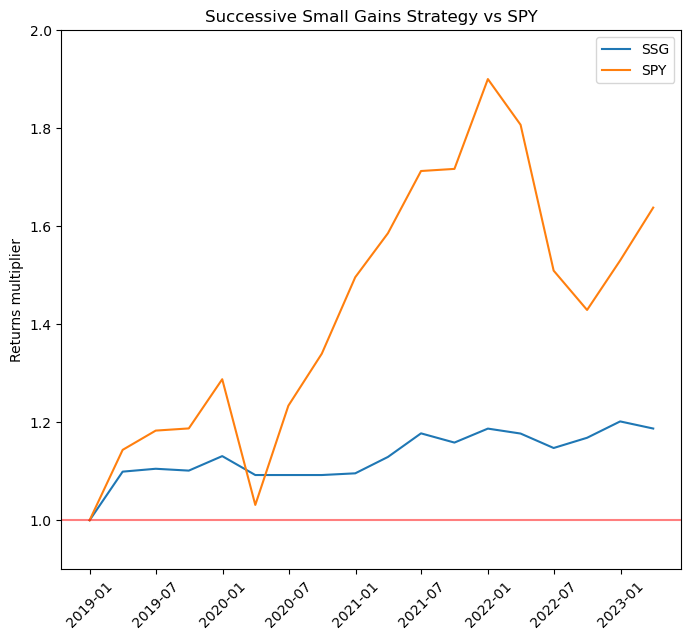

In [151]:
def plot_vs_spy(returns_dict):
    fig, ax = plt.subplots()
    fig.set_size_inches(8,7)
    x = returns_dict.keys()
    y1 = returns_dict.values()
    ax.plot(x,y1, label="SSG")

    spyy = spy.values
    ax.plot(x, spyy, label="SPY")
    
    ax.set_ylim(0.9,2)
    plt.axhline(1, c='r', alpha=0.5)
    
    ax.legend()
    ax.set_ylabel("Returns multiplier")
    ax.set_title("Successive Small Gains Strategy vs SPY")
    plt.xticks(rotation=45)
plot_vs_spy(returns_dict)